In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm
# import pipvis as vp
from importlib import reload
from salishsea_tools import (
viz_tools)


# Section: Seasonal and regional distributions of aragonite saturation state

Here we consider seasonal dynamics and interannual variability in aragonite saturation state in the Salish Sea, subdivided into three dynamical regions: the Northern Strait of Georgia, the Central Strait of Georgia, and the Juan de Fuca Strait. We focus on conditions at the surface, in the intermediate layer (50m), and at depth (at 200m). 

    ...
Summary of dynamical regions as per cluster paper: 
    - JdF: highly mixed, deep-water inflow, deep haloclines
    - CSoG: Fraser-stratified system, shallow haloclines, low aragonite when low salinity
    - NSog: diminished importance of Fraser, intermediate haloclines
    
    ...
We are using the following definition of seasons. (This is partly to avoid the middle-of-winter discontinuity as, e.g. December 2017 goes to January 2017.) 
        
    - Winter (prebloom) Jday 1-59
    - Spring bloom – Jday 60-130 cite Allen and Wolf
    - Productive season – Jday 131—mean(236,235,247,245,249) - 242 for end cite Moore-Maley and Allen
    - Fall/end of year Jday 242(ish)-365

#### A first cut of the three dynamical regions, based on year 2015 clustering

In [4]:
tcl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/BIO_clno_5_2015_reass.pkl'
xs_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Xcoords_for571_stations.pkl'
ys_pkl = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/Ycoords_for571_stations.pkl'

cldes = pickle.load(open(tcl, 'rb'))
xs = pickle.load(open(xs_pkl, 'rb'))
ys = pickle.load(open(ys_pkl, 'rb'))

ys_csog = ys[cldes == 3]
xs_csog = xs[cldes == 3]

ys_nsog = ys[cldes == 4]
xs_nsog = xs[cldes == 4]

ys_jdf = ys[cldes == 5]
xs_jdf = xs[cldes == 5]

bath = '/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc'
grid = nc.Dataset(bath)
# print(grid)
# print(grid['gdept_1d'][0,26])
tmask = (grid['tmask'][0,0,:,:])
tmask
regmask = np.copy(tmask)
tmask_24 = (grid['tmask'][0,24,:,:])
regmask_24 = np.copy(tmask)
tmask_26 = (grid['tmask'][0,26,:,:])
regmask_26 = np.copy(tmask)

for i in range(0,len(ys_csog)):
    tx = xs_csog[i]
    ty = ys_csog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 3
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 3
for i in range(0,len(ys_nsog)):
    tx = xs_nsog[i]
    ty = ys_nsog[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 4
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 4
for i in range(0,len(ys_jdf)):
    tx = xs_jdf[i]
    ty = ys_jdf[i]
    regmask[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_24[ty-5:ty+5,tx-5:tx+5] = 5
    regmask_26[ty-5:ty+5,tx-5:tx+5] = 5

regmask[tmask==0] = 0
regmask_24[tmask_24==0] = 0
regmask_26[tmask_26==0] = 0

## adjust your regmask

xs = np.zeros([898,398])
ys = np.zeros([898,398])

for i in range(0,398):
    xs[:,i] = i
for j in range(0,898):
    ys[j,:] = j
    
regmask[(regmask == 5) & (ys > 700)] = 1
regmask[(regmask == 5) & (xs < 20)] = 1
regmask[(regmask == 3) & (ys < 225)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs < 290)] = 1
regmask[(regmask == 3) & (ys < 350) & (xs > 290)] = 1
regmask[(regmask == 3) & (ys < 300) & (xs > 280) & (xs < 320)] = 1
# tmask[(regmask == 5) & (ys > 700)] = 1

regmask_3d = np.zeros([40,898,398])

for i in range(0,40):
    regmask_3d[i,:] = regmask

tmask = (grid['tmask'][0,:,:,:])
regmask_3d[tmask == 0] = 0
    

No handles with labels found to put in legend.


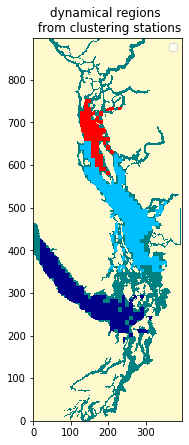

In [6]:
import matplotlib.colors as colors

fact = 1
fig = plt.figure(figsize=(9.1*fact, 7.09*fact))
ax = plt.subplot2grid((3,3), (0,1), colspan=1, rowspan=3)
#ax.text(0.04,.94,'f)', fontsize = 12, weight = 'bold', transform=ax.transAxes)
viz_tools.set_aspect(ax)    

cmap = colors.ListedColormap(['lemonchiffon','teal','chartreuse','deepskyblue','red','darkblue'])
boundaries = [0,1,2,3,4,5,6]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
w = plt.pcolormesh(regmask, cmap=cmap, norm=norm)
#plt.colorbar(w)
ax.set_title('dynamical regions \n from clustering stations')

# ax = plt.subplot2grid((3,3), (0,0), colspan=1, rowspan=3)
# ts = 10
# mesh = ax.pcolormesh(tmask, vmin=0, vmax=2, cmap = cm.cm.deep)
# pts = ax.scatter(xs_jdf,ys_jdf,\
#                  s=ts,c='darkblue',marker='.', label = 'JdF')
# pts = ax.scatter(xs_csog,ys_csog,\
#                  s=ts,c='deepskyblue',marker='.', label = 'CSoG')
# pts = ax.scatter(xs_nsog,ys_nsog,\
#                  s=ts,c='red',marker='.', label = 'NSoG')
# ax.set_title('clustering stations')
plt.legend()

In [7]:
#open the layers profiles
#[0,10,18,24,26]

OmA_2017_FY_D_0 = pickle.load(open('./pkls/OmA_2017_FY_D_0.pkl', 'rb'))  
OmA_2017_FY_D_24 = pickle.load(open('./pkls/OmA_2017_FY_D_24.pkl', 'rb'))  
OmA_2017_FY_D_26 = pickle.load(open('./pkls/OmA_2017_FY_D_26.pkl', 'rb'))  
OmA_2017_FY_D_0[OmA_2017_FY_D_0>1e10] = np.nan
OmA_2017_FY_D_24[OmA_2017_FY_D_24>1e10] = np.nan
OmA_2017_FY_D_26[OmA_2017_FY_D_26>1e10] = np.nan

CAR50_4_OmA_2017_FY_D_0 = pickle.load(open('./pkls/CAR50_4_OmA_2017_FY_D_0.pkl', 'rb'))  
CAR50_4_OmA_2017_FY_D_24 = pickle.load(open('./pkls/CAR50_4_OmA_2017_FY_D_24.pkl', 'rb'))  
CAR50_4_OmA_2017_FY_D_26 = pickle.load(open('./pkls/CAR50_4_OmA_2017_FY_D_26.pkl', 'rb'))  
CAR50_4_OmA_2017_FY_D_0[CAR50_4_OmA_2017_FY_D_0>1e10] = np.nan
CAR50_4_OmA_2017_FY_D_24[CAR50_4_OmA_2017_FY_D_24>1e10] = np.nan
CAR50_4_OmA_2017_FY_D_26[CAR50_4_OmA_2017_FY_D_26>1e10] = np.nan

# OmA_2013_FY_D_0 = pickle.load(open('./pkls/OmA_2013_FY_D_0.pkl', 'rb'))  
# OmA_2013_FY_D_24 = pickle.load(open('./pkls/OmA_2013_FY_D_24.pkl', 'rb'))  
# OmA_2013_FY_D_26 = pickle.load(open('./pkls/OmA_2013_FY_D_26.pkl', 'rb'))  
# OmA_2013_FY_D_0[OmA_2013_FY_D_0>1e10] = np.nan
# OmA_2013_FY_D_24[OmA_2013_FY_D_24>1e10] = np.nan
# OmA_2013_FY_D_26[OmA_2013_FY_D_26>1e10] = np.nan

# OmA_2014_FY_D_0 = pickle.load(open('./pkls/OmA_2014_FY_D_0.pkl', 'rb'))  
# OmA_2014_FY_D_24 = pickle.load(open('./pkls/OmA_2014_FY_D_24.pkl', 'rb'))  
# OmA_2014_FY_D_26 = pickle.load(open('./pkls/OmA_2014_FY_D_26.pkl', 'rb'))  
# OmA_2014_FY_D_0[OmA_2014_FY_D_0>1e10] = np.nan
# OmA_2014_FY_D_24[OmA_2014_FY_D_24>1e10] = np.nan
# OmA_2014_FY_D_26[OmA_2014_FY_D_26>1e10] = np.nan

# OmA_2015_FY_D_0 = pickle.load(open('./pkls/OmA_2015_FY_D_0.pkl', 'rb'))  
# OmA_2015_FY_D_24 = pickle.load(open('./pkls/OmA_2015_FY_D_24.pkl', 'rb'))  
# OmA_2015_FY_D_26 = pickle.load(open('./pkls/OmA_2015_FY_D_26.pkl', 'rb'))  
# OmA_2015_FY_D_0[OmA_2015_FY_D_0>1e10] = np.nan
# OmA_2015_FY_D_24[OmA_2015_FY_D_24>1e10] = np.nan
# OmA_2015_FY_D_26[OmA_2015_FY_D_26>1e10] = np.nan


In [ ]:
# OmA_2016_FY_D_0 = pickle.load(open('./pkls/OmA_2016_FY_D_0.pkl', 'rb'))  
# OmA_2016_FY_D_24 = pickle.load(open('./pkls/OmA_2016_FY_D_24.pkl', 'rb'))  
# OmA_2016_FY_D_26 = pickle.load(open('./pkls/OmA_2016_FY_D_26.pkl', 'rb'))  
# OmA_2016_FY_D_0[OmA_2016_FY_D_0>1e10] = np.nan
# OmA_2016_FY_D_24[OmA_2016_FY_D_24>1e10] = np.nan
# OmA_2016_FY_D_26[OmA_2016_FY_D_26>1e10] = np.nan

###### this bit is heavy-handed extractive code for means, std devs, minima and maxima of the 3 regions for years 2013-2017 (hadn't extracted 2016, need to do)

In [16]:
#mean,stddev,min_max
#metric, region, depth (0,24,26), season/day

TS_2017 = np.zeros([4,3,3,365])
SEAS_2017 = np.zeros([4,3,3,4])

for i in range(0,365):
    td = OmA_2017_FY_D_0[i,:,:]
    for reg in range(0,3):
        TS_2017[0,reg,0,i] = np.nanmean(td[regmask == reg+3]);
        TS_2017[1,reg,0,i] = np.nanstd(td[regmask == reg+3]);
        TS_2017[2,reg,0,i] = np.nanmin(td[regmask == reg+3]);
        TS_2017[3,reg,0,i] = np.nanmax(td[regmask == reg+3]);
        
    td = OmA_2017_FY_D_24[i,:,:]
    for reg in range(0,3):
        TS_2017[0,reg,1,i] = np.nanmean(td[regmask_24 == reg+3]);
        TS_2017[1,reg,1,i] = np.nanstd(td[regmask_24 == reg+3]);
        TS_2017[2,reg,1,i] = np.nanmin(td[regmask_24 == reg+3]);
        TS_2017[3,reg,1,i] = np.nanmax(td[regmask_24 == reg+3])

    td = OmA_2017_FY_D_26[i,:,:]
    for reg in range(0,3):
        TS_2017[0,reg,2,i] = np.nanmean(td[regmask_26 == reg+3]);
        TS_2017[1,reg,2,i] = np.nanstd(td[regmask_26 == reg+3]);
        TS_2017[2,reg,2,i] = np.nanmin(td[regmask_26 == reg+3]);
        TS_2017[3,reg,2,i] = np.nanmax(td[regmask_26 == reg+3])

CAR50_TS_2017 = np.zeros([4,3,3,365])
CAR50_SEAS_2017 = np.zeros([4,3,3,4])

for i in range(0,365):
    td = CAR50_4_OmA_2017_FY_D_0[i,:,:]
    for reg in range(0,3):
        CAR50_TS_2017[0,reg,0,i] = np.nanmean(td[regmask == reg+3]);
        CAR50_TS_2017[1,reg,0,i] = np.nanstd(td[regmask == reg+3]);
        CAR50_TS_2017[2,reg,0,i] = np.nanmin(td[regmask == reg+3]);
        CAR50_TS_2017[3,reg,0,i] = np.nanmax(td[regmask == reg+3]);
        
    td = CAR50_4_OmA_2017_FY_D_24[i,:,:]
    for reg in range(0,3):
        CAR50_TS_2017[0,reg,1,i] = np.nanmean(td[regmask_24 == reg+3]);
        CAR50_TS_2017[1,reg,1,i] = np.nanstd(td[regmask_24 == reg+3]);
        CAR50_TS_2017[2,reg,1,i] = np.nanmin(td[regmask_24 == reg+3]);
        CAR50_TS_2017[3,reg,1,i] = np.nanmax(td[regmask_24 == reg+3])

    td = CAR50_4_OmA_2017_FY_D_26[i,:,:]
    for reg in range(0,3):
        CAR50_TS_2017[0,reg,2,i] = np.nanmean(td[regmask_26 == reg+3]);
        CAR50_TS_2017[1,reg,2,i] = np.nanstd(td[regmask_26 == reg+3]);
        CAR50_TS_2017[2,reg,2,i] = np.nanmin(td[regmask_26 == reg+3]);
        CAR50_TS_2017[3,reg,2,i] = np.nanmax(td[regmask_26 == reg+3])

In [23]:
WP_start = 0; WP_end = 59
SB_start = 59; SB_end = 129
PS_start = 129; PS_end = 242
EOY_start = 242; EOY_end = 365

starts = [WP_start,SB_start,PS_start,EOY_start]
ends = [WP_end,SB_end,PS_end,EOY_end]

for seas in range(0,4):
    t_start = starts[seas]; t_end = ends[seas];

    td = OmA_2017_FY_D_0[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        SEAS_2017[0,reg,0,seas] = np.nanmean(td[regmask_broad == reg+3]);
        SEAS_2017[1,reg,0,seas] = np.nanstd(td[regmask_broad == reg+3]);
        SEAS_2017[2,reg,0,seas] = np.nanmin(td[regmask_broad == reg+3]);
        SEAS_2017[3,reg,0,seas] = np.nanmax(td[regmask_broad == reg+3]);


  
for seas in range(0,4):
    t_start = starts[seas]; t_end = ends[seas];

    td = OmA_2017_FY_D_24[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        SEAS_2017[0,reg,1,seas] = np.nanmean(td[regmask_broad == reg+3]);
        SEAS_2017[1,reg,1,seas] = np.nanstd(td[regmask_broad == reg+3]);
        SEAS_2017[2,reg,1,seas] = np.nanmin(td[regmask_broad == reg+3]);
        SEAS_2017[3,reg,1,seas] = np.nanmax(td[regmask_broad == reg+3]);
        
        
for seas in range(0,4):
    t_start = starts[seas]; t_end = ends[seas];

    td = OmA_2017_FY_D_26[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        SEAS_2017[0,reg,2,seas] = np.nanmean(td[regmask_broad == reg+3]);
        SEAS_2017[1,reg,2,seas] = np.nanstd(td[regmask_broad == reg+3]);
        SEAS_2017[2,reg,2,seas] = np.nanmin(td[regmask_broad == reg+3]);
        SEAS_2017[3,reg,2,seas] = np.nanmax(td[regmask_broad == reg+3]);



In [17]:
WP_start = 0; WP_end = 59
SB_start = 59; SB_end = 129
PS_start = 129; PS_end = 242
EOY_start = 242; EOY_end = 365

starts = [WP_start,SB_start,PS_start,EOY_start]
ends = [WP_end,SB_end,PS_end,EOY_end]

for CAR50_SEAS in range(0,4):
    t_start = starts[CAR50_SEAS]; t_end = ends[CAR50_SEAS];

    td = CAR50_4_OmA_2017_FY_D_0[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        CAR50_SEAS_2017[0,reg,0,CAR50_SEAS] = np.nanmean(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[1,reg,0,CAR50_SEAS] = np.nanstd(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[2,reg,0,CAR50_SEAS] = np.nanmin(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[3,reg,0,CAR50_SEAS] = np.nanmax(td[regmask_broad == reg+3]);


  
for CAR50_SEAS in range(0,4):
    t_start = starts[CAR50_SEAS]; t_end = ends[CAR50_SEAS];

    td = CAR50_4_OmA_2017_FY_D_24[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        CAR50_SEAS_2017[0,reg,1,CAR50_SEAS] = np.nanmean(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[1,reg,1,CAR50_SEAS] = np.nanstd(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[2,reg,1,CAR50_SEAS] = np.nanmin(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[3,reg,1,CAR50_SEAS] = np.nanmax(td[regmask_broad == reg+3]);
        
        
for CAR50_SEAS in range(0,4):
    t_start = starts[CAR50_SEAS]; t_end = ends[CAR50_SEAS];

    td = CAR50_4_OmA_2017_FY_D_26[t_start:t_end,:,:]
    regmask_broad = np.zeros_like(td)

    for i in range(0,regmask_broad.shape[0]):
        regmask_broad[i,:,:] = regmask
        
    for reg in range(0,3):   
        CAR50_SEAS_2017[0,reg,2,CAR50_SEAS] = np.nanmean(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[1,reg,2,CAR50_SEAS] = np.nanstd(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[2,reg,2,CAR50_SEAS] = np.nanmin(td[regmask_broad == reg+3]);
        CAR50_SEAS_2017[3,reg,2,CAR50_SEAS] = np.nanmax(td[regmask_broad == reg+3]);



In [18]:
CAR50_SEAS_2017

array([[[[0.77072349, 1.20461764, 1.76157292, 1.11326926],
         [0.75605653, 0.79930278, 0.76946646, 0.70928839],
         [0.74555709, 0.784096  , 0.77013672, 0.71052381]],

        [[0.83453796, 1.29251398, 2.18284688, 1.2060494 ],
         [0.71660143, 0.73749363, 0.7153273 , 0.67943231],
         [0.68949446, 0.71042497, 0.68682616, 0.65173485]],

        [[0.91137849, 1.12754853, 1.4979617 , 0.95682719],
         [0.89655258, 1.05389951, 0.82598891, 0.75829465],
         [0.89317964, 1.01686595, 0.68358883, 0.65964779]]],


       [[[0.11417411, 0.49347918, 0.54781396, 0.50683705],
         [0.03099439, 0.0648887 , 0.08678761, 0.04968962],
         [0.03392966, 0.05296865, 0.06769909, 0.03542429]],

        [[0.03959812, 0.53844706, 0.24602584, 0.52176696],
         [0.02058507, 0.03446967, 0.05127328, 0.04503803],
         [0.01930667, 0.0197746 , 0.03692835, 0.03451399]],

        [[0.10167113, 0.18179009, 0.28764947, 0.21355534],
         [0.09994083, 0.05692597, 0.13216864

In [24]:
SEAS_2017

array([[[[0.9262415 , 1.35459525, 1.97513241, 1.27812303],
         [0.93709772, 0.96885528, 0.92454114, 0.85476073],
         [0.91614582, 0.96519258, 0.93889648, 0.85417713]],

        [[1.00533649, 1.44994219, 2.43294965, 1.37817527],
         [0.87142701, 0.89271682, 0.86860186, 0.82280362],
         [0.83324131, 0.86024156, 0.84067398, 0.79163533]],

        [[1.10657432, 1.3230661 , 1.70605414, 1.11897106],
         [1.10619298, 1.25287237, 0.98128205, 0.90264286],
         [1.09622041, 1.21510102, 0.8120643 , 0.78781884]]],


       [[[0.13644634, 0.51428826, 0.60168977, 0.54704457],
         [0.04396848, 0.07336765, 0.09725157, 0.05295811],
         [0.05160839, 0.06639658, 0.07439283, 0.0377577 ]],

        [[0.03915823, 0.55300004, 0.26084443, 0.5553309 ],
         [0.02097474, 0.03870069, 0.06247873, 0.05030021],
         [0.01762675, 0.02472945, 0.04597343, 0.03806374]],

        [[0.09802778, 0.18953877, 0.30131285, 0.23327729],
         [0.09999614, 0.06057144, 0.15464578

In [ ]:
year_boxes[3]

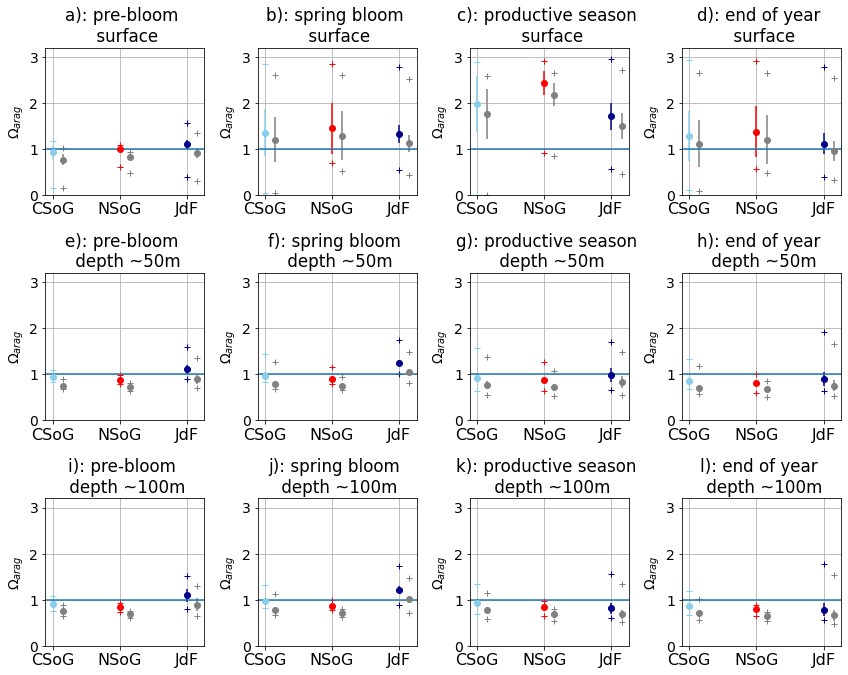

In [33]:

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}


year_boxes= [SEAS_2017, CAR50_SEAS_2017]
#metric, region, depth (0,24,26), season/day
cols = ['skyblue','red','darkblue']
fact = 0.6
fig, axs = plt.subplots(3,4, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a].errorbar(reg+y*0.15, t_year[0,reg,0,a],yerr = t_year[1,reg,0,a],\
                           marker = 'o', color = cols[reg])
            axs[a].plot(reg+y*0.15, t_year[2,reg,0,a], marker = '+', color = cols[reg])
            axs[a].plot(reg+y*0.15, t_year[3,reg,0,a], marker = '+', color = cols[reg])
        for y in range(1,2):

            t_year = year_boxes[y]
            axs[a].errorbar(reg+y*0.15, t_year[0,reg,0,a],yerr = t_year[1,reg,0,a],\
                           marker = 'o', color = 'grey')
            axs[a].plot(reg+y*0.15, t_year[2,reg,0,a], marker = '+', color = 'grey')
            axs[a].plot(reg+y*0.15, t_year[3,reg,0,a], marker = '+', color = 'grey')                

for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a+4].errorbar(reg+y*0.15, t_year[0,reg,1,a],yerr = t_year[1,reg,1,a],\
                           marker = 'o', color = cols[reg])
            axs[a+4].plot(reg+y*0.15, t_year[2,reg,1,a], marker = '+', color = cols[reg])
            axs[a+4].plot(reg+y*0.15, t_year[3,reg,1,a], marker = '+', color = cols[reg])
        for y in range(1,2):

            t_year = year_boxes[y]
            axs[a+4].errorbar(reg+y*0.15, t_year[0,reg,1,a],yerr = t_year[1,reg,1,a],\
                           marker = 'o', color = 'grey')
            axs[a+4].plot(reg+y*0.15, t_year[2,reg,1,a], marker = '+', color = 'grey')
            axs[a+4].plot(reg+y*0.15, t_year[3,reg,1,a], marker = '+', color = 'grey')                

            
            
for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a+8].errorbar(reg+y*0.15, t_year[0,reg,2,a],yerr = t_year[1,reg,2,a],\
                           marker = 'o', color = cols[reg])
            axs[a+8].plot(reg+y*0.15, t_year[2,reg,2,a], marker = '+', color = cols[reg])
            axs[a+8].plot(reg+y*0.15, t_year[3,reg,2,a], marker = '+', color = cols[reg])
        for y in range(1,2):

            t_year = year_boxes[y]
            axs[a+8].errorbar(reg+y*0.15, t_year[0,reg,2,a],yerr = t_year[1,reg,2,a],\
                           marker = 'o', color = 'grey')
            axs[a+8].plot(reg+y*0.15, t_year[2,reg,2,a], marker = '+', color = 'grey')
            axs[a+8].plot(reg+y*0.15, t_year[3,reg,2,a], marker = '+', color = 'grey')      

tseas = 'walrus'
lets = ['a','b','c','d','e','f','g','h','i','j','k','l']
for i in range(0,12):
    axs[i].set_xticks([0,1,2])
    axs[i].set_xticklabels(['CSoG','NSoG','JdF'], fontsize = 16)
    axs[i].set_ylabel('$\Omega_{arag}$')
    axs[i].set_ylim([0,3.2])
    axs[i].grid()

    if i%4 == 0:
        tseas = 'pre-bloom'
    if i%4 == 1:
        tseas = 'spring bloom'
    if i%4 == 2:
        tseas = 'productive season'
    if i%4 == 3:
        tseas = 'end of year'
    
    if i<12: tdepth = 'depth ~100m';
    if i<8: tdepth = 'depth ~50m';
    if i<4: tdepth = 'surface';
    let = lets[i]
    
    
    
        
    axs[i].set_title(f'{let}): {tseas} \n {tdepth}')
    axs[i].axhline(y=1)
    
plt.tight_layout()

-0.15551800983247055
-0.1707985323424991
-0.1951958241178272
-0.14997760533796023
-0.15742820322042173
-0.19551756623177274
-0.21355948286169246
-0.25010276446052737
-0.20809243687262935
-0.16485376721099532
-0.17212587441849836
-0.16214386739376352


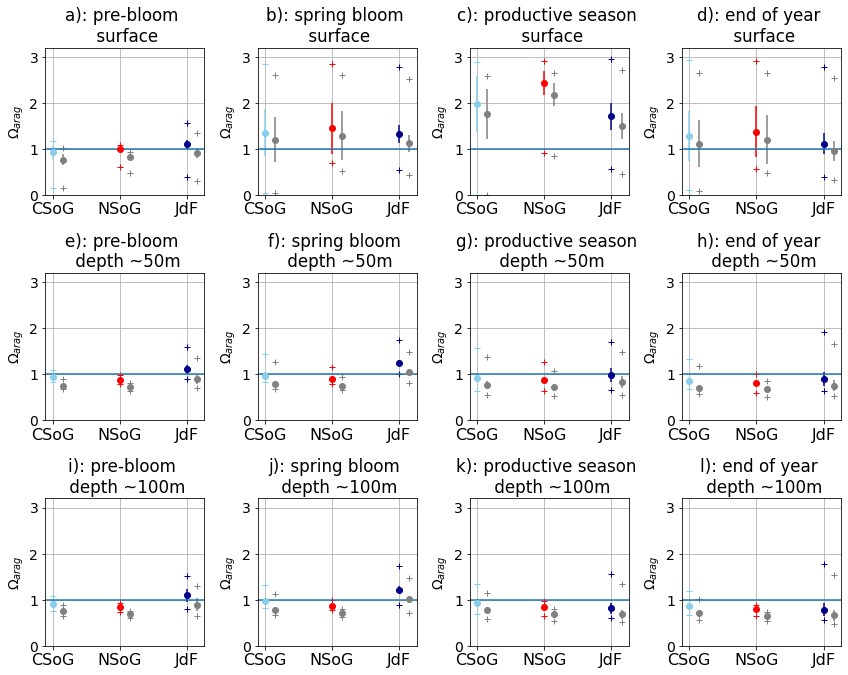

In [34]:

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}


year_boxes= [SEAS_2017, CAR50_SEAS_2017]
#metric, region, depth (0,24,26), season/day
cols = ['skyblue','red','darkblue']
fact = 0.6
fig, axs = plt.subplots(3,4, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a].errorbar(reg+y*0.15, t_year[0,reg,0,a],yerr = t_year[1,reg,0,a],\
                           marker = 'o', color = cols[reg])
            axs[a].plot(reg+y*0.15, t_year[2,reg,0,a], marker = '+', color = cols[reg])
            axs[a].plot(reg+y*0.15, t_year[3,reg,0,a], marker = '+', color = cols[reg])
            q =  t_year[0,reg,0,a]
        for y in range(1,2):
            
            t_year = year_boxes[y]
            axs[a].errorbar(reg+y*0.15, t_year[0,reg,0,a],yerr = t_year[1,reg,0,a],\
                           marker = 'o', color = 'grey')
            axs[a].plot(reg+y*0.15, t_year[2,reg,0,a], marker = '+', color = 'grey')
            axs[a].plot(reg+y*0.15, t_year[3,reg,0,a], marker = '+', color = 'grey')                
            q2 = t_year[0,reg,0,a]
        print(q2-q)
for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a+4].errorbar(reg+y*0.15, t_year[0,reg,1,a],yerr = t_year[1,reg,1,a],\
                           marker = 'o', color = cols[reg])
            axs[a+4].plot(reg+y*0.15, t_year[2,reg,1,a], marker = '+', color = cols[reg])
            axs[a+4].plot(reg+y*0.15, t_year[3,reg,1,a], marker = '+', color = cols[reg])
        for y in range(1,2):

            t_year = year_boxes[y]
            axs[a+4].errorbar(reg+y*0.15, t_year[0,reg,1,a],yerr = t_year[1,reg,1,a],\
                           marker = 'o', color = 'grey')
            axs[a+4].plot(reg+y*0.15, t_year[2,reg,1,a], marker = '+', color = 'grey')
            axs[a+4].plot(reg+y*0.15, t_year[3,reg,1,a], marker = '+', color = 'grey')                

            
            
for a in range(0,4):
    for reg in range(0,3):
        for y in range(0,1):

            t_year = year_boxes[y]
            axs[a+8].errorbar(reg+y*0.15, t_year[0,reg,2,a],yerr = t_year[1,reg,2,a],\
                           marker = 'o', color = cols[reg])
            axs[a+8].plot(reg+y*0.15, t_year[2,reg,2,a], marker = '+', color = cols[reg])
            axs[a+8].plot(reg+y*0.15, t_year[3,reg,2,a], marker = '+', color = cols[reg])
        for y in range(1,2):

            t_year = year_boxes[y]
            axs[a+8].errorbar(reg+y*0.15, t_year[0,reg,2,a],yerr = t_year[1,reg,2,a],\
                           marker = 'o', color = 'grey')
            axs[a+8].plot(reg+y*0.15, t_year[2,reg,2,a], marker = '+', color = 'grey')
            axs[a+8].plot(reg+y*0.15, t_year[3,reg,2,a], marker = '+', color = 'grey')      

tseas = 'walrus'
lets = ['a','b','c','d','e','f','g','h','i','j','k','l']
for i in range(0,12):
    axs[i].set_xticks([0,1,2])
    axs[i].set_xticklabels(['CSoG','NSoG','JdF'], fontsize = 16)
    axs[i].set_ylabel('$\Omega_{arag}$')
    axs[i].set_ylim([0,3.2])
    axs[i].grid()

    if i%4 == 0:
        tseas = 'pre-bloom'
    if i%4 == 1:
        tseas = 'spring bloom'
    if i%4 == 2:
        tseas = 'productive season'
    if i%4 == 3:
        tseas = 'end of year'
    
    if i<12: tdepth = 'depth ~100m';
    if i<8: tdepth = 'depth ~50m';
    if i<4: tdepth = 'surface';
    let = lets[i]
    
    
    
        
    axs[i].set_title(f'{let}): {tseas} \n {tdepth}')
    axs[i].axhline(y=1)
    
plt.tight_layout()

In [37]:
ttir = SEAS_2017[0,:,:,:] - CAR50_SEAS_2017[0,:,:,:]
print(ttir)
np.max(ttir)

[[[0.15551801 0.14997761 0.21355948 0.16485377]
  [0.18104119 0.1695525  0.15507468 0.14547233]
  [0.17058873 0.18109658 0.16875976 0.14365332]]

 [[0.17079853 0.1574282  0.25010276 0.17212587]
  [0.15482558 0.15522319 0.15327456 0.14337131]
  [0.14374685 0.14981659 0.15384782 0.13990048]]

 [[0.19519582 0.19551757 0.20809244 0.16214387]
  [0.2096404  0.19897286 0.15529314 0.14434821]
  [0.20304077 0.19823507 0.12847547 0.12817104]]]


0.25010276446052737

In [ ]:
year_boxes= [TS_2013,TS_2014,TS_2015,TS_2016,TS_2017]
#metric, region, depth (0,24,26), season/day

fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
daze = np.arange(0,365,1)
axs[0].plot(daze,TS_2017[0,0,0,:], color = 'skyblue', linewidth = 2)
axs[0].fill_between(daze,TS_2017[0,0,0,:]+TS_2017[1,0,0,:],\
                    TS_2017[0,0,0,:]-TS_2017[1,0,0,:],\
                    alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[0].plot(daze,TS_2017[2,0,0,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,TS_2017[3,0,0,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
#Nsog
axs[0].plot(daze,TS_2017[0,1,0,:], color = 'red', linewidth = 2)
axs[0].fill_between(daze,TS_2017[0,1,0,:]+TS_2017[1,1,0,:],\
                    TS_2017[0,1,0,:]-TS_2017[1,1,0,:],\
                    alpha = 0.2,color = 'red', linewidth = 2)
axs[0].plot(daze,TS_2017[2,1,0,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,TS_2017[3,1,0,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,TS_2017[0,2,0,:], color = 'darkblue', linewidth = 2)
axs[0].fill_between(daze,TS_2017[0,2,0,:]+TS_2017[1,2,0,:],\
                    TS_2017[0,2,0,:]-TS_2017[1,2,0,:],\
                    alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[0].plot(daze,TS_2017[2,2,0,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,TS_2017[3,2,0,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
#####
axs[1].plot(daze,TS_2017[0,0,1,:], color = 'skyblue', linewidth = 2)
axs[1].fill_between(daze,TS_2017[0,0,1,:]+TS_2017[1,0,1,:],\
                    TS_2017[0,0,1,:]-TS_2017[1,0,1,:],\
                    alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,TS_2017[2,0,1,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,TS_2017[3,0,1,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
#Nsog
axs[1].plot(daze,TS_2017[0,1,1,:], color = 'red', linewidth = 2)
axs[1].fill_between(daze,TS_2017[0,1,1,:]+TS_2017[1,1,1,:],\
                    TS_2017[0,1,1,:]-TS_2017[1,1,1,:],\
                    alpha = 0.2,color = 'red', linewidth = 2)
axs[1].plot(daze,TS_2017[2,1,1,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,TS_2017[3,1,1,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,TS_2017[0,0,1,:], color = 'skyblue', linewidth = 2)
axs[1].fill_between(daze,TS_2017[0,0,1,:]+TS_2017[1,0,1,:],\
                    TS_2017[0,0,1,:]-TS_2017[1,0,1,:],\
                    alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,TS_2017[2,0,1,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,TS_2017[3,0,1,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
#Nsog
axs[1].plot(daze,TS_2017[0,2,1,:], color = 'darkblue', linewidth = 2)
axs[1].fill_between(daze,TS_2017[0,2,1,:]+TS_2017[1,2,1,:],\
                    TS_2017[0,2,1,:]-TS_2017[1,2,1,:],\
                    alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[1].plot(daze,TS_2017[2,2,1,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,TS_2017[3,2,1,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,TS_2017[0,0,2,:], color = 'skyblue', linewidth = 2)
axs[2].fill_between(daze,TS_2017[0,0,2,:]+TS_2017[1,0,2,:],\
                    TS_2017[0,0,2,:]-TS_2017[1,0,2,:],\
                    alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,TS_2017[2,0,2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,TS_2017[3,0,2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
#Nsog
axs[2].plot(daze,TS_2017[0,1,2,:], color = 'red', linewidth = 2)
axs[2].fill_between(daze,TS_2017[0,1,2,:]+TS_2017[1,1,2,:],\
                    TS_2017[0,1,2,:]-TS_2017[1,1,2,:],\
                    alpha = 0.2,color = 'red', linewidth = 2)
axs[2].plot(daze,TS_2017[2,1,2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,TS_2017[3,1,2,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,TS_2017[0,0,2,:], color = 'skyblue', linewidth = 2)
axs[2].fill_between(daze,TS_2017[0,0,2,:]+TS_2017[1,0,2,:],\
                    TS_2017[0,0,2,:]-TS_2017[1,0,2,:],\
                    alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,TS_2017[2,0,2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,TS_2017[3,0,2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
#Nsog
axs[2].plot(daze,TS_2017[0,2,2,:], color = 'darkblue', linewidth = 2)
axs[2].fill_between(daze,TS_2017[0,2,2,:]+TS_2017[1,2,2,:],\
                    TS_2017[0,2,2,:]-TS_2017[1,2,2,:],\
                    alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[2].plot(daze,TS_2017[2,2,2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,TS_2017[3,2,2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

for i in range(0,3):
    axs[i].set_xlim([0,365])
    axs[i].set_ylim([0,3])
    axs[i].set_ylabel('$\Omega_A$')
    axs[i].set_xlabel('day of year')
    axs[i].grid()
axs[0].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, surface (by region)')
axs[1].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, depth = 58m')
axs[2].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, depth = 100')

plt.tight_layout()

## years 2013-2015,2017

In [ ]:
year_boxes= [TS_2013,TS_2014,TS_2015,TS_2016,TS_2017]
#metric, region, depth (0,24,26), season/day

fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
daze = np.arange(0,365,1)

for ts in range(0,5):
    t_ts = year_boxes[ts]
    axs[0].plot(daze,t_ts[0,0,0,:], color = 'skyblue', linewidth = 2)
    axs[0].fill_between(daze,t_ts[0,0,0,:]+t_ts[1,0,0,:],\
                        t_ts[0,0,0,:]-t_ts[1,0,0,:],\
                        alpha = 0.2,color = 'skyblue', linewidth = 2)
    axs[0].plot(daze,t_ts[2,0,0,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    axs[0].plot(daze,t_ts[3,0,0,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    #Nsog
    axs[0].plot(daze,t_ts[0,1,0,:], color = 'red', linewidth = 2)
    axs[0].fill_between(daze,t_ts[0,1,0,:]+t_ts[1,1,0,:],\
                        t_ts[0,1,0,:]-t_ts[1,1,0,:],\
                        alpha = 0.2,color = 'red', linewidth = 2)
    axs[0].plot(daze,t_ts[2,1,0,:], color = 'red', \
                linestyle = ':', linewidth = 2)
    axs[0].plot(daze,t_ts[3,1,0,:], color = 'red', \
                linestyle = ':', linewidth = 2)

    axs[0].plot(daze,t_ts[0,2,0,:], color = 'darkblue', linewidth = 2)
    axs[0].fill_between(daze,t_ts[0,2,0,:]+t_ts[1,2,0,:],\
                        t_ts[0,2,0,:]-t_ts[1,2,0,:],\
                        alpha = 0.2,color = 'darkblue', linewidth = 2)
    axs[0].plot(daze,t_ts[2,2,0,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)
    axs[0].plot(daze,t_ts[3,2,0,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)
    #####
    axs[1].plot(daze,t_ts[0,0,1,:], color = 'skyblue', linewidth = 2)
    axs[1].fill_between(daze,t_ts[0,0,1,:]+t_ts[1,0,1,:],\
                        t_ts[0,0,1,:]-t_ts[1,0,1,:],\
                        alpha = 0.2,color = 'skyblue', linewidth = 2)
    axs[1].plot(daze,t_ts[2,0,1,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    axs[1].plot(daze,t_ts[3,0,1,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    #Nsog
    axs[1].plot(daze,t_ts[0,1,1,:], color = 'red', linewidth = 2)
    axs[1].fill_between(daze,t_ts[0,1,1,:]+t_ts[1,1,1,:],\
                        t_ts[0,1,1,:]-t_ts[1,1,1,:],\
                        alpha = 0.2,color = 'red', linewidth = 2)
    axs[1].plot(daze,t_ts[2,1,1,:], color = 'red', \
                linestyle = ':', linewidth = 2)
    axs[1].plot(daze,t_ts[3,1,1,:], color = 'red', \
                linestyle = ':', linewidth = 2)
    axs[1].plot(daze,t_ts[0,0,1,:], color = 'skyblue', linewidth = 2)
    axs[1].fill_between(daze,t_ts[0,0,1,:]+t_ts[1,0,1,:],\
                        t_ts[0,0,1,:]-t_ts[1,0,1,:],\
                        alpha = 0.2,color = 'skyblue', linewidth = 2)
    axs[1].plot(daze,t_ts[2,0,1,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    axs[1].plot(daze,t_ts[3,0,1,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    #Nsog
    axs[1].plot(daze,t_ts[0,2,1,:], color = 'darkblue', linewidth = 2)
    axs[1].fill_between(daze,t_ts[0,2,1,:]+t_ts[1,2,1,:],\
                        t_ts[0,2,1,:]-t_ts[1,2,1,:],\
                        alpha = 0.2,color = 'darkblue', linewidth = 2)
    axs[1].plot(daze,t_ts[2,2,1,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)
    axs[1].plot(daze,t_ts[3,2,1,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)

    axs[2].plot(daze,t_ts[0,0,2,:], color = 'skyblue', linewidth = 2)
    axs[2].fill_between(daze,t_ts[0,0,2,:]+t_ts[1,0,2,:],\
                        t_ts[0,0,2,:]-t_ts[1,0,2,:],\
                        alpha = 0.2,color = 'skyblue', linewidth = 2)
    axs[2].plot(daze,t_ts[2,0,2,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    axs[2].plot(daze,t_ts[3,0,2,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    #Nsog
    axs[2].plot(daze,t_ts[0,1,2,:], color = 'red', linewidth = 2)
    axs[2].fill_between(daze,t_ts[0,1,2,:]+t_ts[1,1,2,:],\
                        t_ts[0,1,2,:]-t_ts[1,1,2,:],\
                        alpha = 0.2,color = 'red', linewidth = 2)
    axs[2].plot(daze,t_ts[2,1,2,:], color = 'red', \
                linestyle = ':', linewidth = 2)
    axs[2].plot(daze,t_ts[3,1,2,:], color = 'red', \
                linestyle = ':', linewidth = 2)

    axs[2].plot(daze,t_ts[0,0,2,:], color = 'skyblue', linewidth = 2)
    axs[2].fill_between(daze,t_ts[0,0,2,:]+t_ts[1,0,2,:],\
                        t_ts[0,0,2,:]-t_ts[1,0,2,:],\
                        alpha = 0.2,color = 'skyblue', linewidth = 2)
    axs[2].plot(daze,t_ts[2,0,2,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    axs[2].plot(daze,t_ts[3,0,2,:], color = 'skyblue', \
                linestyle = ':', linewidth = 2)
    #Nsog
    axs[2].plot(daze,t_ts[0,2,2,:], color = 'darkblue', linewidth = 2)
    axs[2].fill_between(daze,t_ts[0,2,2,:]+t_ts[1,2,2,:],\
                        t_ts[0,2,2,:]-t_ts[1,2,2,:],\
                        alpha = 0.2,color = 'darkblue', linewidth = 2)
    axs[2].plot(daze,t_ts[2,2,2,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)
    axs[2].plot(daze,t_ts[3,2,2,:], color = 'darkblue', \
                linestyle = ':', linewidth = 2)

for i in range(0,3):
    axs[i].set_xlim([0,365])
    axs[i].set_ylim([0,3])
    axs[i].set_ylabel('$\Omega_A$')
    axs[i].set_xlabel('day of year')
    axs[i].grid()
axs[0].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, surface (by region)')
axs[1].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, depth = 58m')
axs[2].set_title('YEAR 2017, Mean (std.dev and max/min indicated) $\Omega_A$, depth = 100')

plt.tight_layout()

In [ ]:
#mean,stddev,min_max
Jdf_TS_2013_D_0 = np.zeros([4,365])
NSoG_TS_2013_D_0 = np.zeros([4,365])
CSoG_TS_2013_D_0 = np.zeros([4,365])

Jdf_TS_2013_D_24 = np.zeros([4,365])
NSoG_TS_2013_D_24 = np.zeros([4,365])
CSoG_TS_2013_D_24 = np.zeros([4,365])

Jdf_TS_2013_D_26 = np.zeros([4,365])
NSoG_TS_2013_D_26 = np.zeros([4,365])
CSoG_TS_2013_D_26 = np.zeros([4,365])

for i in range(0,365):
    td = OmA_2013_FY_D_0[i,:,:]
    Jdf_TS_2013_D_0[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2013_D_0[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2013_D_0[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2013_D_0[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2013_D_0[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2013_D_0[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2013_D_0[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2013_D_0[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2013_D_0[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2013_D_0[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2013_D_0[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2013_D_0[3,i] = np.nanmax(td[regmask == 3]);

    td = OmA_2013_FY_D_24[i,:,:]
    Jdf_TS_2013_D_24[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2013_D_24[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2013_D_24[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2013_D_24[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2013_D_24[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2013_D_24[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2013_D_24[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2013_D_24[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2013_D_24[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2013_D_24[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2013_D_24[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2013_D_24[3,i] = np.nanmax(td[regmask == 3]);
    
    td = OmA_2013_FY_D_26[i,:,:]
    Jdf_TS_2013_D_26[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2013_D_26[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2013_D_26[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2013_D_26[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2013_D_26[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2013_D_26[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2013_D_26[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2013_D_26[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2013_D_26[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2013_D_26[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2013_D_26[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2013_D_26[3,i] = np.nanmax(td[regmask == 3]);

In [ ]:
#mean,stddev,min_max
Jdf_TS_2014_D_0 = np.zeros([4,365])
NSoG_TS_2014_D_0 = np.zeros([4,365])
CSoG_TS_2014_D_0 = np.zeros([4,365])

Jdf_TS_2014_D_24 = np.zeros([4,365])
NSoG_TS_2014_D_24 = np.zeros([4,365])
CSoG_TS_2014_D_24 = np.zeros([4,365])

Jdf_TS_2014_D_26 = np.zeros([4,365])
NSoG_TS_2014_D_26 = np.zeros([4,365])
CSoG_TS_2014_D_26 = np.zeros([4,365])

for i in range(0,365):
    td = OmA_2014_FY_D_0[i,:,:]
    Jdf_TS_2014_D_0[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2014_D_0[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2014_D_0[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2014_D_0[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2014_D_0[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2014_D_0[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2014_D_0[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2014_D_0[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2014_D_0[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2014_D_0[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2014_D_0[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2014_D_0[3,i] = np.nanmax(td[regmask == 3]);

    td = OmA_2014_FY_D_24[i,:,:]
    Jdf_TS_2014_D_24[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2014_D_24[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2014_D_24[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2014_D_24[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2014_D_24[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2014_D_24[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2014_D_24[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2014_D_24[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2014_D_24[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2014_D_24[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2014_D_24[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2014_D_24[3,i] = np.nanmax(td[regmask == 3]);
    
    td = OmA_2014_FY_D_26[i,:,:]
    Jdf_TS_2014_D_26[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2014_D_26[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2014_D_26[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2014_D_26[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2014_D_26[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2014_D_26[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2014_D_26[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2014_D_26[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2014_D_26[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2014_D_26[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2014_D_26[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2014_D_26[3,i] = np.nanmax(td[regmask == 3]);

In [ ]:
#mean,stddev,min_max
Jdf_TS_2015_D_0 = np.zeros([4,365])
NSoG_TS_2015_D_0 = np.zeros([4,365])
CSoG_TS_2015_D_0 = np.zeros([4,365])

Jdf_TS_2015_D_24 = np.zeros([4,365])
NSoG_TS_2015_D_24 = np.zeros([4,365])
CSoG_TS_2015_D_24 = np.zeros([4,365])

Jdf_TS_2015_D_26 = np.zeros([4,365])
NSoG_TS_2015_D_26 = np.zeros([4,365])
CSoG_TS_2015_D_26 = np.zeros([4,365])

for i in range(0,365):
    td = OmA_2015_FY_D_0[i,:,:]
    Jdf_TS_2015_D_0[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2015_D_0[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2015_D_0[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2015_D_0[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2015_D_0[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2015_D_0[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2015_D_0[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2015_D_0[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2015_D_0[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2015_D_0[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2015_D_0[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2015_D_0[3,i] = np.nanmax(td[regmask == 3]);

    td = OmA_2015_FY_D_24[i,:,:]
    Jdf_TS_2015_D_24[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2015_D_24[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2015_D_24[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2015_D_24[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2015_D_24[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2015_D_24[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2015_D_24[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2015_D_24[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2015_D_24[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2015_D_24[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2015_D_24[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2015_D_24[3,i] = np.nanmax(td[regmask == 3]);
    
    td = OmA_2015_FY_D_26[i,:,:]
    Jdf_TS_2015_D_26[0,i] = np.nanmean(td[regmask == 5]);
    Jdf_TS_2015_D_26[1,i] = np.nanstd(td[regmask == 5]);
    Jdf_TS_2015_D_26[2,i] = np.nanmin(td[regmask == 5]);
    Jdf_TS_2015_D_26[3,i] = np.nanmax(td[regmask == 5]);
    
    NSoG_TS_2015_D_26[0,i] = np.nanmean(td[regmask == 4]);
    NSoG_TS_2015_D_26[1,i] = np.nanstd(td[regmask == 4]);
    NSoG_TS_2015_D_26[2,i] = np.nanmin(td[regmask == 4]);
    NSoG_TS_2015_D_26[3,i] = np.nanmax(td[regmask == 4]);
    
    CSoG_TS_2015_D_26[0,i] = np.nanmean(td[regmask == 3]);
    CSoG_TS_2015_D_26[1,i] = np.nanstd(td[regmask == 3]);
    CSoG_TS_2015_D_26[2,i] = np.nanmin(td[regmask == 3]);
    CSoG_TS_2015_D_26[3,i] = np.nanmax(td[regmask == 3]);

#### Explore a 'representative year' (2017) aragonite saturation cycle at surface, intermediate, and deep waters, with extrema and standard deviation visualised

In [ ]:
fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
daze = np.arange(0,365,1)

axs[0].plot(daze,CSoG_TS_2013_D_0[0,:], color = 'skyblue', linewidth = 2)
# axs[0].fill_between(daze,CSoG_TS_2013_D_0[0,:]+CSoG_TS_2013_D_0[1,:],\
#                     CSoG_TS_2013_D_0[0,:]-CSoG_TS_2013_D_0[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2013_D_0[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2013_D_0[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,NSoG_TS_2013_D_0[0,:], color = 'red', linewidth = 2)
# axs[0].fill_between(daze,NSoG_TS_2013_D_0[0,:]+NSoG_TS_2013_D_0[1,:],\
#                     NSoG_TS_2013_D_0[0,:]-NSoG_TS_2013_D_0[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2013_D_0[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2013_D_0[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,Jdf_TS_2013_D_0[0,:], color = 'darkblue', linewidth = 2)
# axs[0].fill_between(daze,Jdf_TS_2013_D_0[0,:]+Jdf_TS_2013_D_0[1,:],\
#                     Jdf_TS_2013_D_0[0,:]-Jdf_TS_2013_D_0[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2013_D_0[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2013_D_0[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,CSoG_TS_2013_D_24[0,:], color = 'skyblue', linewidth = 2)
# axs[1].fill_between(daze,CSoG_TS_2013_D_24[0,:]+CSoG_TS_2013_D_24[1,:],\
#                     CSoG_TS_2013_D_24[0,:]-CSoG_TS_2013_D_24[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2013_D_24[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2013_D_24[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,NSoG_TS_2013_D_24[0,:], color = 'red', linewidth = 2)
# axs[1].fill_between(daze,NSoG_TS_2013_D_24[0,:]+NSoG_TS_2013_D_24[1,:],\
#                     NSoG_TS_2013_D_24[0,:]-NSoG_TS_2013_D_24[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2013_D_24[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2013_D_24[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,Jdf_TS_2013_D_24[0,:], color = 'darkblue', linewidth = 2)
# axs[1].fill_between(daze,Jdf_TS_2013_D_24[0,:]+Jdf_TS_2013_D_24[1,:],\
#                     Jdf_TS_2013_D_24[0,:]-Jdf_TS_2013_D_24[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2013_D_24[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2013_D_24[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,CSoG_TS_2013_D_26[0,:], color = 'skyblue', linewidth = 2)
# axs[2].fill_between(daze,CSoG_TS_2013_D_26[0,:]+CSoG_TS_2013_D_26[1,:],\
#                     CSoG_TS_2013_D_26[0,:]-CSoG_TS_2013_D_26[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2013_D_26[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2013_D_26[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,NSoG_TS_2013_D_26[0,:], color = 'red', linewidth = 2)
# axs[2].fill_between(daze,NSoG_TS_2013_D_26[0,:]+NSoG_TS_2013_D_26[1,:],\
#                     NSoG_TS_2013_D_26[0,:]-NSoG_TS_2013_D_26[1,:],\
#                    alpha = 0.2,color = 'red', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2013_D_26[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2013_D_26[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,Jdf_TS_2013_D_26[0,:], color = 'darkblue', linewidth = 2)
# axs[2].fill_between(daze,Jdf_TS_2013_D_26[0,:]+Jdf_TS_2013_D_26[1,:],\
#                     Jdf_TS_2013_D_26[0,:]-Jdf_TS_2013_D_26[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2013_D_26[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2013_D_26[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,CSoG_TS_2014_D_0[0,:], color = 'skyblue', linewidth = 2)
# axs[0].fill_between(daze,CSoG_TS_2014_D_0[0,:]+CSoG_TS_2014_D_0[1,:],\
#                     CSoG_TS_2014_D_0[0,:]-CSoG_TS_2014_D_0[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2014_D_0[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2014_D_0[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,NSoG_TS_2014_D_0[0,:], color = 'red', linewidth = 2)
# axs[0].fill_between(daze,NSoG_TS_2014_D_0[0,:]+NSoG_TS_2014_D_0[1,:],\
#                     NSoG_TS_2014_D_0[0,:]-NSoG_TS_2014_D_0[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2014_D_0[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2014_D_0[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,Jdf_TS_2014_D_0[0,:], color = 'darkblue', linewidth = 2)
# axs[0].fill_between(daze,Jdf_TS_2014_D_0[0,:]+Jdf_TS_2014_D_0[1,:],\
#                     Jdf_TS_2014_D_0[0,:]-Jdf_TS_2014_D_0[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2014_D_0[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2014_D_0[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,CSoG_TS_2014_D_24[0,:], color = 'skyblue', linewidth = 2)
# axs[1].fill_between(daze,CSoG_TS_2014_D_24[0,:]+CSoG_TS_2014_D_24[1,:],\
#                     CSoG_TS_2014_D_24[0,:]-CSoG_TS_2014_D_24[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2014_D_24[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2014_D_24[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,NSoG_TS_2014_D_24[0,:], color = 'red', linewidth = 2)
# axs[1].fill_between(daze,NSoG_TS_2014_D_24[0,:]+NSoG_TS_2014_D_24[1,:],\
#                     NSoG_TS_2014_D_24[0,:]-NSoG_TS_2014_D_24[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2014_D_24[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2014_D_24[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,Jdf_TS_2014_D_24[0,:], color = 'darkblue', linewidth = 2)
# axs[1].fill_between(daze,Jdf_TS_2014_D_24[0,:]+Jdf_TS_2014_D_24[1,:],\
#                     Jdf_TS_2014_D_24[0,:]-Jdf_TS_2014_D_24[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2014_D_24[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2014_D_24[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,CSoG_TS_2014_D_26[0,:], color = 'skyblue', linewidth = 2)
# axs[2].fill_between(daze,CSoG_TS_2014_D_26[0,:]+CSoG_TS_2014_D_26[1,:],\
#                     CSoG_TS_2014_D_26[0,:]-CSoG_TS_2014_D_26[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2014_D_26[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2014_D_26[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,NSoG_TS_2014_D_26[0,:], color = 'red', linewidth = 2)
# axs[2].fill_between(daze,NSoG_TS_2014_D_26[0,:]+NSoG_TS_2014_D_26[1,:],\
#                     NSoG_TS_2014_D_26[0,:]-NSoG_TS_2014_D_26[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2014_D_26[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2014_D_26[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,Jdf_TS_2014_D_26[0,:], color = 'darkblue', linewidth = 2)
# axs[2].fill_between(daze,Jdf_TS_2014_D_26[0,:]+Jdf_TS_2014_D_26[1,:],\
#                     Jdf_TS_2014_D_26[0,:]-Jdf_TS_2014_D_26[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2014_D_26[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2014_D_26[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,CSoG_TS_2015_D_0[0,:], color = 'skyblue', linewidth = 2)
# axs[0].fill_between(daze,CSoG_TS_2015_D_0[0,:]+CSoG_TS_2015_D_0[1,:],\
#                     CSoG_TS_2015_D_0[0,:]-CSoG_TS_2015_D_0[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2015_D_0[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2015_D_0[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,NSoG_TS_2015_D_0[0,:], color = 'red', linewidth = 2)
# axs[0].fill_between(daze,NSoG_TS_2015_D_0[0,:]+NSoG_TS_2015_D_0[1,:],\
#                     NSoG_TS_2015_D_0[0,:]-NSoG_TS_2015_D_0[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2015_D_0[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2015_D_0[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,Jdf_TS_2015_D_0[0,:], color = 'darkblue', linewidth = 2)
# axs[0].fill_between(daze,Jdf_TS_2015_D_0[0,:]+Jdf_TS_2015_D_0[1,:],\
#                     Jdf_TS_2015_D_0[0,:]-Jdf_TS_2015_D_0[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2015_D_0[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2015_D_0[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,CSoG_TS_2015_D_24[0,:], color = 'skyblue', linewidth = 2)
# axs[1].fill_between(daze,CSoG_TS_2015_D_24[0,:]+CSoG_TS_2015_D_24[1,:],\
#                     CSoG_TS_2015_D_24[0,:]-CSoG_TS_2015_D_24[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2015_D_24[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2015_D_24[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,NSoG_TS_2015_D_24[0,:], color = 'red', linewidth = 2)
# axs[1].fill_between(daze,NSoG_TS_2015_D_24[0,:]+NSoG_TS_2015_D_24[1,:],\
#                     NSoG_TS_2015_D_24[0,:]-NSoG_TS_2015_D_24[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2015_D_24[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2015_D_24[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,Jdf_TS_2015_D_24[0,:], color = 'darkblue', linewidth = 2)
# axs[1].fill_between(daze,Jdf_TS_2015_D_24[0,:]+Jdf_TS_2015_D_24[1,:],\
#                     Jdf_TS_2015_D_24[0,:]-Jdf_TS_2015_D_24[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2015_D_24[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2015_D_24[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,CSoG_TS_2015_D_26[0,:], color = 'skyblue', linewidth = 2)
# axs[2].fill_between(daze,CSoG_TS_2015_D_26[0,:]+CSoG_TS_2015_D_26[1,:],\
#                     CSoG_TS_2015_D_26[0,:]-CSoG_TS_2015_D_26[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2015_D_26[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2015_D_26[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,NSoG_TS_2015_D_26[0,:], color = 'red', linewidth = 2)
# axs[2].fill_between(daze,NSoG_TS_2015_D_26[0,:]+NSoG_TS_2015_D_26[1,:],\
#                     NSoG_TS_2015_D_26[0,:]-NSoG_TS_2015_D_26[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2015_D_26[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2015_D_26[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,Jdf_TS_2015_D_26[0,:], color = 'darkblue', linewidth = 2)
# axs[2].fill_between(daze,Jdf_TS_2015_D_26[0,:]+Jdf_TS_2015_D_26[1,:],\
#                     Jdf_TS_2015_D_26[0,:]-Jdf_TS_2015_D_26[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2015_D_26[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2015_D_26[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)


axs[0].plot(daze,CSoG_TS_2017_D_0[0,:], color = 'skyblue', linewidth = 2)
# axs[0].fill_between(daze,CSoG_TS_2017_D_0[0,:]+CSoG_TS_2017_D_0[1,:],\
#                     CSoG_TS_2017_D_0[0,:]-CSoG_TS_2017_D_0[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2017_D_0[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,CSoG_TS_2017_D_0[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,NSoG_TS_2017_D_0[0,:], color = 'red', linewidth = 2)
# axs[0].fill_between(daze,NSoG_TS_2017_D_0[0,:]+NSoG_TS_2017_D_0[1,:],\
#                     NSoG_TS_2017_D_0[0,:]-NSoG_TS_2017_D_0[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2017_D_0[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,NSoG_TS_2017_D_0[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[0].plot(daze,Jdf_TS_2017_D_0[0,:], color = 'darkblue', linewidth = 2)
# axs[0].fill_between(daze,Jdf_TS_2017_D_0[0,:]+Jdf_TS_2017_D_0[1,:],\
#                     Jdf_TS_2017_D_0[0,:]-Jdf_TS_2017_D_0[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2017_D_0[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[0].plot(daze,Jdf_TS_2017_D_0[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,CSoG_TS_2017_D_24[0,:], color = 'skyblue', linewidth = 2)
# axs[1].fill_between(daze,CSoG_TS_2017_D_24[0,:]+CSoG_TS_2017_D_24[1,:],\
#                     CSoG_TS_2017_D_24[0,:]-CSoG_TS_2017_D_24[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2017_D_24[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,CSoG_TS_2017_D_24[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,NSoG_TS_2017_D_24[0,:], color = 'red', linewidth = 2)
# axs[1].fill_between(daze,NSoG_TS_2017_D_24[0,:]+NSoG_TS_2017_D_24[1,:],\
#                     NSoG_TS_2017_D_24[0,:]-NSoG_TS_2017_D_24[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2017_D_24[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,NSoG_TS_2017_D_24[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[1].plot(daze,Jdf_TS_2017_D_24[0,:], color = 'darkblue', linewidth = 2)
#axs[1].fill_between(daze,Jdf_TS_2017_D_24[0,:]+Jdf_TS_2017_D_24[1,:],\
#                     Jdf_TS_2017_D_24[0,:]-Jdf_TS_2017_D_24[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2017_D_24[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[1].plot(daze,Jdf_TS_2017_D_24[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,CSoG_TS_2017_D_26[0,:], color = 'skyblue', linewidth = 2)
#axs[2].fill_between(daze,CSoG_TS_2017_D_26[0,:]+CSoG_TS_2017_D_26[1,:],\
#                     CSoG_TS_2017_D_26[0,:]-CSoG_TS_2017_D_26[1,:],\
#                     alpha = 0.2,color = 'skyblue', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2017_D_26[2,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,CSoG_TS_2017_D_26[3,:], color = 'skyblue', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,NSoG_TS_2017_D_26[0,:], color = 'red', linewidth = 2)
#axs[2].fill_between(daze,NSoG_TS_2017_D_26[0,:]+NSoG_TS_2017_D_26[1,:],\
#                     NSoG_TS_2017_D_26[0,:]-NSoG_TS_2017_D_26[1,:],\
#                     alpha = 0.2,color = 'red', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2017_D_26[2,:], color = 'red', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,NSoG_TS_2017_D_26[3,:], color = 'red', \
            linestyle = ':', linewidth = 2)

axs[2].plot(daze,Jdf_TS_2017_D_26[0,:], color = 'darkblue', linewidth = 2)
# axs[2].fill_between(daze,Jdf_TS_2017_D_26[0,:]+Jdf_TS_2017_D_26[1,:],\
#                     Jdf_TS_2017_D_26[0,:]-Jdf_TS_2017_D_26[1,:],\
#                     alpha = 0.2,color = 'darkblue', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2017_D_26[2,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)
axs[2].plot(daze,Jdf_TS_2017_D_26[3,:], color = 'darkblue', \
            linestyle = ':', linewidth = 2)

for i in range(0,3):
    axs[i].set_xlim([0,365])
    axs[i].set_ylim([0,3])
    axs[i].set_ylabel('$\Omega_A$')
    axs[i].set_xlabel('day of year')
    axs[i].grid()
axs[0].set_title('YEARS 2013-2017 (no 2016), Mean (std.dev and max/min indicated) $\Omega_A$, surface (by region)')
axs[1].set_title('YEARS 2013-2017 (no 2016), Mean (std.dev and max/min indicated) $\Omega_A$, depth = 58m')
axs[2].set_title('YEARS 2013-2017 (no 2016), Mean (std.dev and max/min indicated) $\Omega_A$, depth = 100')

plt.tight_layout()

### produce a figure of summary statistics
### 

In [ ]:
WP_start = 0; WP_end = 59
SB_start = 59; SB_end = 129
PS_start = 129; PS_end = 242
EOY_start = 242; EOY_end = 365

#     - Winter (prebloom) Jday 1-59
#     - Spring bloom – Jday 60-130 cite Allen and Wolf
#     - Productive season – Jday 131—mean(236,235,247,245,249) - 242 for end cite Moore-Maley and Allen
#     - Fall/end of year Jday 242(ish)-365

#years, regions(3), depths(3) seasons (4), stats (4), mean, std, min, max)

sumstats = np.zeros([5,3,3,4,4])

#depth 0, CSoG, year 2017, all sesons


#one year one region one depth, stats
sumstats[4,0,0,0,0] = np.nanmean(CSoG_TS_2017_D_0[0,WP_start:WP_end])
sumstats[4,0,0,0,1] = np.nanstd(CSoG_TS_2017_D_0[0,WP_start:WP_end])
sumstats[4,0,0,0,2] = np.nanmin(CSoG_TS_2017_D_0[0,WP_start:WP_end])
sumstats[4,0,0,0,3] = np.nanmax(CSoG_TS_2017_D_0[0,WP_start:WP_end])

sumstats[4,0,0,1,0] = np.nanmean(CSoG_TS_2017_D_0[0,SB_start:SB_end])
sumstats[4,0,0,1,1] = np.nanstd(CSoG_TS_2017_D_0[0,SB_start:SB_end])
sumstats[4,0,0,1,2] = np.nanmin(CSoG_TS_2017_D_0[0,SB_start:SB_end])
sumstats[4,0,0,1,3] = np.nanmax(CSoG_TS_2017_D_0[0,SB_start:SB_end])

sumstats[4,0,0,2,0] = np.nanmean(CSoG_TS_2017_D_0[0,PS_start:PS_end])
sumstats[4,0,0,2,1] = np.nanstd(CSoG_TS_2017_D_0[0,PS_start:PS_end])
sumstats[4,0,0,2,2] = np.nanmin(CSoG_TS_2017_D_0[0,PS_start:PS_end])
sumstats[4,0,0,2,3] = np.nanmax(CSoG_TS_2017_D_0[0,PS_start:PS_end])

sumstats[4,0,0,3,0] = np.nanmean(CSoG_TS_2017_D_0[0,EOY_start:EOY_end])
sumstats[4,0,0,3,1] = np.nanstd(CSoG_TS_2017_D_0[0,EOY_start:EOY_end])
sumstats[4,0,0,3,2] = np.nanmin(CSoG_TS_2017_D_0[0,EOY_start:EOY_end])
sumstats[4,0,0,3,3] = np.nanmax(CSoG_TS_2017_D_0[0,EOY_start:EOY_end])


sumstats[2,0,0,0,0] = np.nanmean(CSoG_TS_2015_D_0[0,WP_start:WP_end])
sumstats[2,0,0,0,1] = np.nanstd(CSoG_TS_2015_D_0[0,WP_start:WP_end])
sumstats[2,0,0,0,2] = np.nanmin(CSoG_TS_2015_D_0[0,WP_start:WP_end])
sumstats[2,0,0,0,3] = np.nanmax(CSoG_TS_2015_D_0[0,WP_start:WP_end])

sumstats[2,0,0,1,0] = np.nanmean(CSoG_TS_2015_D_0[0,SB_start:SB_end])
sumstats[2,0,0,1,1] = np.nanstd(CSoG_TS_2015_D_0[0,SB_start:SB_end])
sumstats[2,0,0,1,2] = np.nanmin(CSoG_TS_2015_D_0[0,SB_start:SB_end])
sumstats[2,0,0,1,3] = np.nanmax(CSoG_TS_2015_D_0[0,SB_start:SB_end])

sumstats[2,0,0,2,0] = np.nanmean(CSoG_TS_2015_D_0[0,PS_start:PS_end])
sumstats[2,0,0,2,1] = np.nanstd(CSoG_TS_2015_D_0[0,PS_start:PS_end])
sumstats[2,0,0,2,2] = np.nanmin(CSoG_TS_2015_D_0[0,PS_start:PS_end])
sumstats[2,0,0,2,3] = np.nanmax(CSoG_TS_2015_D_0[0,PS_start:PS_end])

sumstats[2,0,0,3,0] = np.nanmean(CSoG_TS_2015_D_0[0,EOY_start:EOY_end])
sumstats[2,0,0,3,1] = np.nanstd(CSoG_TS_2015_D_0[0,EOY_start:EOY_end])
sumstats[2,0,0,3,2] = np.nanmin(CSoG_TS_2015_D_0[0,EOY_start:EOY_end])
sumstats[2,0,0,3,3] = np.nanmax(CSoG_TS_2015_D_0[0,EOY_start:EOY_end])

sumstats[0,0,0,0,0] = np.nanmean(CSoG_TS_2013_D_0[0,WP_start:WP_end])
sumstats[0,0,0,0,1] = np.nanstd(CSoG_TS_2013_D_0[0,WP_start:WP_end])
sumstats[0,0,0,0,2] = np.nanmin(CSoG_TS_2013_D_0[0,WP_start:WP_end])
sumstats[0,0,0,0,3] = np.nanmax(CSoG_TS_2013_D_0[0,WP_start:WP_end])

sumstats[0,0,0,1,0] = np.nanmean(CSoG_TS_2013_D_0[0,SB_start:SB_end])
sumstats[0,0,0,1,1] = np.nanstd(CSoG_TS_2013_D_0[0,SB_start:SB_end])
sumstats[0,0,0,1,2] = np.nanmin(CSoG_TS_2013_D_0[0,SB_start:SB_end])
sumstats[0,0,0,1,3] = np.nanmax(CSoG_TS_2013_D_0[0,SB_start:SB_end])

sumstats[0,0,0,2,0] = np.nanmean(CSoG_TS_2013_D_0[0,PS_start:PS_end])
sumstats[0,0,0,2,1] = np.nanstd(CSoG_TS_2013_D_0[0,PS_start:PS_end])
sumstats[0,0,0,2,2] = np.nanmin(CSoG_TS_2013_D_0[0,PS_start:PS_end])
sumstats[0,0,0,2,3] = np.nanmax(CSoG_TS_2013_D_0[0,PS_start:PS_end])

sumstats[0,0,0,3,0] = np.nanmean(CSoG_TS_2013_D_0[0,EOY_start:EOY_end])
sumstats[0,0,0,3,1] = np.nanstd(CSoG_TS_2013_D_0[0,EOY_start:EOY_end])
sumstats[0,0,0,3,2] = np.nanmin(CSoG_TS_2013_D_0[0,EOY_start:EOY_end])
sumstats[0,0,0,3,3] = np.nanmax(CSoG_TS_2013_D_0[0,EOY_start:EOY_end])

sumstats[1,0,0,0,0] = np.nanmean(CSoG_TS_2014_D_0[1,WP_start:WP_end])
sumstats[1,0,0,0,1] = np.nanstd(CSoG_TS_2014_D_0[1,WP_start:WP_end])
sumstats[1,0,0,0,2] = np.nanmin(CSoG_TS_2014_D_0[1,WP_start:WP_end])
sumstats[1,0,0,0,3] = np.nanmax(CSoG_TS_2014_D_0[1,WP_start:WP_end])

sumstats[1,0,0,1,0] = np.nanmean(CSoG_TS_2014_D_0[1,SB_start:SB_end])
sumstats[1,0,0,1,1] = np.nanstd(CSoG_TS_2014_D_0[1,SB_start:SB_end])
sumstats[1,0,0,1,2] = np.nanmin(CSoG_TS_2014_D_0[1,SB_start:SB_end])
sumstats[1,0,0,1,3] = np.nanmax(CSoG_TS_2014_D_0[1,SB_start:SB_end])

sumstats[1,0,0,2,0] = np.nanmean(CSoG_TS_2014_D_0[1,PS_start:PS_end])
sumstats[1,0,0,2,1] = np.nanstd(CSoG_TS_2014_D_0[1,PS_start:PS_end])
sumstats[1,0,0,2,2] = np.nanmin(CSoG_TS_2014_D_0[1,PS_start:PS_end])
sumstats[1,0,0,2,3] = np.nanmax(CSoG_TS_2014_D_0[1,PS_start:PS_end])

sumstats[1,0,0,3,0] = np.nanmean(CSoG_TS_2014_D_0[1,EOY_start:EOY_end])
sumstats[1,0,0,3,1] = np.nanstd(CSoG_TS_2014_D_0[1,EOY_start:EOY_end])
sumstats[1,0,0,3,2] = np.nanmin(CSoG_TS_2014_D_0[1,EOY_start:EOY_end])
sumstats[1,0,0,3,3] = np.nanmax(CSoG_TS_2014_D_0[1,EOY_start:EOY_end])
######
# sumstats[4,1,1,0,0] = np.nanmean(NSoG_TS_2017_D_0[0,WP_start:WP_end])
# sumstats[4,1,1,0,1] = np.nanstd(NSoG_TS_2017_D_0[0,WP_start:WP_end])
# sumstats[4,1,1,0,2] = np.nanmin(NSoG_TS_2017_D_0[0,WP_start:WP_end])
# sumstats[4,1,1,0,3] = np.nanmax(NSoG_TS_2017_D_0[0,WP_start:WP_end])

# sumstats[4,1,0,1,0] = np.nanmean(NSoG_TS_2017_D_0[0,SB_start:SB_end])
# sumstats[4,1,0,1,1] = np.nanstd(NSoG_TS_2017_D_0[0,SB_start:SB_end])
# sumstats[4,1,0,1,2] = np.nanmin(NSoG_TS_2017_D_0[0,SB_start:SB_end])
# sumstats[4,1,0,1,3] = np.nanmax(NSoG_TS_2017_D_0[0,SB_start:SB_end])

# sumstats[4,1,0,2,0] = np.nanmean(NSoG_TS_2017_D_0[0,PS_start:PS_end])
# sumstats[4,1,0,2,1] = np.nanstd(NSoG_TS_2017_D_0[0,PS_start:PS_end])
# sumstats[4,1,0,2,2] = np.nanmin(NSoG_TS_2017_D_0[0,PS_start:PS_end])
# sumstats[4,1,0,2,3] = np.nanmax(NSoG_TS_2017_D_0[0,PS_start:PS_end])

# sumstats[4,1,0,3,0] = np.nanmean(NSoG_TS_2017_D_0[0,EOY_start:EOY_end])
# sumstats[4,1,0,3,1] = np.nanstd(NSoG_TS_2017_D_0[0,EOY_start:EOY_end])
# sumstats[4,1,0,3,2] = np.nanmin(NSoG_TS_2017_D_0[0,EOY_start:EOY_end])
# sumstats[4,1,0,3,3] = np.nanmax(NSoG_TS_2017_D_0[0,EOY_start:EOY_end])


# sumstats[2,1,1,0,0] = np.nanmean(NSoG_TS_2015_D_0[0,WP_start:WP_end])
# sumstats[2,1,1,0,1] = np.nanstd(NSoG_TS_2015_D_0[0,WP_start:WP_end])
# sumstats[2,1,1,0,2] = np.nanmin(NSoG_TS_2015_D_0[0,WP_start:WP_end])
# sumstats[2,1,1,0,3] = np.nanmax(NSoG_TS_2015_D_0[0,WP_start:WP_end])

# sumstats[2,1,0,1,0] = np.nanmean(NSoG_TS_2015_D_0[0,SB_start:SB_end])
# sumstats[2,1,0,1,1] = np.nanstd(NSoG_TS_2015_D_0[0,SB_start:SB_end])
# sumstats[2,1,0,1,2] = np.nanmin(NSoG_TS_2015_D_0[0,SB_start:SB_end])
# sumstats[2,1,0,1,3] = np.nanmax(NSoG_TS_2015_D_0[0,SB_start:SB_end])

# sumstats[2,1,0,2,0] = np.nanmean(NSoG_TS_2015_D_0[0,PS_start:PS_end])
# sumstats[2,1,0,2,1] = np.nanstd(NSoG_TS_2015_D_0[0,PS_start:PS_end])
# sumstats[2,1,0,2,2] = np.nanmin(NSoG_TS_2015_D_0[0,PS_start:PS_end])
# sumstats[2,1,0,2,3] = np.nanmax(NSoG_TS_2015_D_0[0,PS_start:PS_end])

# sumstats[2,1,0,3,0] = np.nanmean(NSoG_TS_2015_D_0[0,EOY_start:EOY_end])
# sumstats[2,1,0,3,1] = np.nanstd(NSoG_TS_2015_D_0[0,EOY_start:EOY_end])
# sumstats[2,1,0,3,2] = np.nanmin(NSoG_TS_2015_D_0[0,EOY_start:EOY_end])
# sumstats[2,1,0,3,3] = np.nanmax(NSoG_TS_2015_D_0[0,EOY_start:EOY_end])

# sumstats[1,1,0,1,0] = np.nanmean(NSoG_TS_2013_D_0[0,WP_start:WP_end])
# sumstats[1,1,0,0,1] = np.nanstd(NSoG_TS_2013_D_0[0,WP_start:WP_end])
# sumstats[1,1,0,0,2] = np.nanmin(NSoG_TS_2013_D_0[0,WP_start:WP_end])
# sumstats[1,1,0,0,3] = np.nanmax(NSoG_TS_2013_D_0[0,WP_start:WP_end])

# sumstats[1,1,0,1,0] = np.nanmean(NSoG_TS_2013_D_0[0,SB_start:SB_end])
# sumstats[1,1,0,1,1] = np.nanstd(NSoG_TS_2013_D_0[0,SB_start:SB_end])
# sumstats[1,1,0,1,2] = np.nanmin(NSoG_TS_2013_D_0[0,SB_start:SB_end])
# sumstats[1,1,0,1,3] = np.nanmax(NSoG_TS_2013_D_0[0,SB_start:SB_end])

# sumstats[1,1,0,2,0] = np.nanmean(NSoG_TS_2013_D_0[0,PS_start:PS_end])
# sumstats[1,1,0,2,1] = np.nanstd(NSoG_TS_2013_D_0[0,PS_start:PS_end])
# sumstats[1,1,0,2,2] = np.nanmin(NSoG_TS_2013_D_0[0,PS_start:PS_end])
# sumstats[1,1,0,2,3] = np.nanmax(NSoG_TS_2013_D_0[0,PS_start:PS_end])

# sumstats[1,1,0,3,0] = np.nanmean(NSoG_TS_2013_D_0[0,EOY_start:EOY_end])
# sumstats[1,1,0,3,1] = np.nanstd(NSoG_TS_2013_D_0[0,EOY_start:EOY_end])
# sumstats[1,1,0,3,2] = np.nanmin(NSoG_TS_2013_D_0[0,EOY_start:EOY_end])
# sumstats[1,1,0,3,3] = np.nanmax(NSoG_TS_2013_D_0[0,EOY_start:EOY_end])

# sumstats[1,1,1,0,0] = np.nanmean(NSoG_TS_2014_D_0[1,WP_start:WP_end])
# sumstats[1,1,1,0,1] = np.nanstd(NSoG_TS_2014_D_0[1,WP_start:WP_end])
# sumstats[1,1,1,0,2] = np.nanmin(NSoG_TS_2014_D_0[1,WP_start:WP_end])
# sumstats[1,1,1,0,3] = np.nanmax(NSoG_TS_2014_D_0[1,WP_start:WP_end])

# sumstats[1,1,0,1,0] = np.nanmean(NSoG_TS_2014_D_0[1,SB_start:SB_end])
# sumstats[1,1,0,1,1] = np.nanstd(NSoG_TS_2014_D_0[1,SB_start:SB_end])
# sumstats[1,1,0,1,2] = np.nanmin(NSoG_TS_2014_D_0[1,SB_start:SB_end])
# sumstats[1,1,0,1,3] = np.nanmax(NSoG_TS_2014_D_0[1,SB_start:SB_end])

# sumstats[1,1,0,2,0] = np.nanmean(NSoG_TS_2014_D_0[1,PS_start:PS_end])
# sumstats[1,1,0,2,1] = np.nanstd(NSoG_TS_2014_D_0[1,PS_start:PS_end])
# sumstats[1,1,0,2,2] = np.nanmin(NSoG_TS_2014_D_0[1,PS_start:PS_end])
# sumstats[1,1,0,2,3] = np.nanmax(NSoG_TS_2014_D_0[1,PS_start:PS_end])

# sumstats[1,1,0,3,0] = np.nanmean(NSoG_TS_2014_D_0[1,EOY_start:EOY_end])
# sumstats[1,1,0,3,1] = np.nanstd(NSoG_TS_2014_D_0[1,EOY_start:EOY_end])
# sumstats[1,1,0,3,2] = np.nanmin(NSoG_TS_2014_D_0[1,EOY_start:EOY_end])
# sumstats[1,1,0,3,3] = np.nanmax(NSoG_TS_2014_D_0[1,EOY_start:EOY_end])


In [ ]:
print((CSoG_TS_2014_D_0[1,WP_start:WP_end]))

In [ ]:
for y in range(0,5):
    print(sumstats[y,0,0,0,0])

In [ ]:
#years, regions(3), depths(3) seasons (4), stats (4), mean, std, min, max)

#csog, nsog, jdf

fact = 0.6
fig, axs = plt.subplots(3,4, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#depth 0, seasons a
for a in range(0,4):
    for y in range(0,5):
        if (y !=3) & (y!=1):
            axs[a].errorbar(1+y*0.05, sumstats[y,0,0,a,0],yerr = sumstats[y,0,0,a,1],\
                           marker = 'o', color = 'skyblue')
#         axs[0].errorbar(2+y*0.05, sumstats[y,1,0,0,0],yerr = sumstats[y,1,0,0,1],\
#                        marker = 'o', color = 'red')

In [ ]:
step = 0.1
t_start = 0
t_end = 3
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)
bin_centres = np.arange(t_start+step/2,t_end + step/2 ,step)
bin_prop = np.zeros_like(bin_centres)

def manual_hist(test_hist):
    for i in range(0,len(bin_starts)):
        obs_in_bin = test_hist[((test_hist>=bin_starts[i]) &\
                               (test_hist<bin_ends[i]))]

        bin_prop[i] = np.size(obs_in_bin)/np.size(test_hist)
    return bin_prop

In [ ]:
spr_st = 59; spr_e = 151
sum_st = 151; sum_e = 243
aut_st = 243; aut_e = 334
win_st = 334; win_e = 365

fig, axs = plt.subplots(1,4, figsize=(14*fact, 20*fact/5), facecolor='w', edgecolor='k')
axs = axs.ravel()

def plot_hists(OmA_2017_FY_D_TNC,inds):
    
    
    win_Oma_2017_TNC = np.concatenate((OmA_2017_FY_D_TNC[0:59,:,:], OmA_2017_FY_D_TNC[win_st:win_e,:,:]), axis = 0)
    win_mean_Oma_2017_TNC = np.nanmean(win_Oma_2017_TNC, axis = 0)
    spr_Oma_2017_TNC = OmA_2017_FY_D_TNC[spr_st:spr_e,:,:]
    spr_mean_Oma_2017_TNC = np.nanmean(spr_Oma_2017_TNC, axis = 0)
    sum_Oma_2017_TNC = OmA_2017_FY_D_TNC[sum_st:sum_e,:,:]
    sum_mean_Oma_2017_TNC = np.nanmean(sum_Oma_2017_TNC, axis = 0)
    aut_Oma_2017_TNC = OmA_2017_FY_D_TNC[aut_st:aut_e,:,:]
    aut_mean_Oma_2017_TNC = np.nanmean(aut_Oma_2017_TNC, axis = 0)
    
    win_csog = win_mean_Oma_2017_TNC[ys_csog,xs_csog]
    twin_csog = win_csog[win_csog < 1e10]
    hist_win_csog = manual_hist(twin_csog)
    thist_win_csog = np.copy(hist_win_csog)
    
    win_nsog = win_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    twin_nsog = win_nsog[win_nsog < 1e10]
    hist_win_nsog = manual_hist(twin_nsog)
    thist_win_nsog = np.copy(hist_win_nsog)
    
    win_jdf = win_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    twin_jdf = win_jdf[win_jdf < 1e10]
    hist_win_jdf = manual_hist(twin_jdf)
    thist_win_jdf = np.copy(hist_win_jdf)
    
    sum_csog = sum_mean_Oma_2017_TNC[ys_csog,xs_csog]
    tsum_csog = sum_csog[sum_csog < 1e10]
    hist_sum_csog = manual_hist(tsum_csog)
    thist_sum_csog = np.copy(hist_sum_csog)
    
    sum_nsog = sum_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    tsum_nsog = sum_nsog[sum_nsog < 1e10]
    hist_sum_nsog = manual_hist(tsum_nsog)
    thist_sum_nsog = np.copy(hist_sum_nsog)
    
    sum_jdf = sum_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    tsum_jdf = sum_jdf[sum_jdf < 1e10]
    hist_sum_jdf = manual_hist(tsum_jdf)
    thist_sum_jdf = np.copy(hist_sum_jdf)
    
    spr_csog = spr_mean_Oma_2017_TNC[ys_csog,xs_csog]
    tspr_csog = spr_csog[spr_csog < 1e10]
    hist_spr_csog = manual_hist(tspr_csog)
    thist_spr_csog = np.copy(hist_spr_csog)
    
    spr_nsog = spr_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    tspr_nsog = spr_nsog[spr_nsog < 1e10]
    hist_spr_nsog = manual_hist(tspr_nsog)
    thist_spr_nsog = np.copy(hist_spr_nsog)
    
    spr_jdf = spr_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    tspr_jdf = spr_jdf[spr_jdf < 1e10]
    hist_spr_jdf = manual_hist(tspr_jdf)
    thist_spr_jdf = np.copy(hist_spr_jdf)
    
    aut_csog = aut_mean_Oma_2017_TNC[ys_csog,xs_csog]
    taut_csog = aut_csog[aut_csog < 1e10]
    hist_aut_csog = manual_hist(taut_csog)
    thist_aut_csog = np.copy(hist_aut_csog)
    
    aut_nsog = aut_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    taut_nsog = aut_nsog[aut_nsog < 1e10]
    hist_aut_nsog = manual_hist(taut_nsog)
    thist_aut_nsog = np.copy(hist_aut_nsog)
    
    aut_jdf = aut_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    taut_jdf = aut_jdf[aut_jdf < 1e10]
    hist_aut_jdf = manual_hist(taut_jdf)
    thist_aut_jdf = np.copy(hist_aut_jdf)

    axs[inds[0]].plot(bin_centres,thist_win_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[0]].plot(bin_centres,thist_win_nsog, linewidth = 2, color = 'red')
    axs[inds[0]].plot(bin_centres,thist_win_jdf, linewidth = 2, color = 'darkblue')
    
    print(np.sum(thist_win_csog))
    axs[inds[1]].plot(bin_centres,thist_spr_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[1]].plot(bin_centres,thist_spr_nsog, linewidth = 2, color = 'red')
    axs[inds[1]].plot(bin_centres,thist_spr_jdf, linewidth = 2, color = 'darkblue')
    print(np.sum(thist_spr_csog))
    axs[inds[2]].plot(bin_centres,thist_sum_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[2]].plot(bin_centres,thist_sum_nsog, linewidth = 2, color = 'red')
    axs[inds[2]].plot(bin_centres,thist_sum_jdf, linewidth = 2, color = 'darkblue')
    
    axs[inds[3]].plot(bin_centres,thist_aut_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[3]].plot(bin_centres,thist_aut_nsog, linewidth = 2, color = 'red')
    axs[inds[3]].plot(bin_centres,thist_aut_jdf, linewidth = 2, color = 'darkblue')


def plot_hists(OmA_2017_FY_D_TNC,inds):
    
    
    win_Oma_2017_TNC = np.concatenate((OmA_2017_FY_D_TNC[0:59,:,:], OmA_2017_FY_D_TNC[win_st:win_e,:,:]), axis = 0)
    win_mean_Oma_2017_TNC = np.nanmean(win_Oma_2017_TNC, axis = 0)
    spr_Oma_2017_TNC = OmA_2017_FY_D_TNC[spr_st:spr_e,:,:]
    spr_mean_Oma_2017_TNC = np.nanmean(spr_Oma_2017_TNC, axis = 0)
    sum_Oma_2017_TNC = OmA_2017_FY_D_TNC[sum_st:sum_e,:,:]
    sum_mean_Oma_2017_TNC = np.nanmean(sum_Oma_2017_TNC, axis = 0)
    aut_Oma_2017_TNC = OmA_2017_FY_D_TNC[aut_st:aut_e,:,:]
    aut_mean_Oma_2017_TNC = np.nanmean(aut_Oma_2017_TNC, axis = 0)
    
    win_csog = win_mean_Oma_2017_TNC[ys_csog,xs_csog]
    twin_csog = win_csog[win_csog < 1e10]
    hist_win_csog = manual_hist(twin_csog)
    thist_win_csog = np.copy(hist_win_csog)
    
    win_nsog = win_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    twin_nsog = win_nsog[win_nsog < 1e10]
    hist_win_nsog = manual_hist(twin_nsog)
    thist_win_nsog = np.copy(hist_win_nsog)
    
    win_jdf = win_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    twin_jdf = win_jdf[win_jdf < 1e10]
    hist_win_jdf = manual_hist(twin_jdf)
    thist_win_jdf = np.copy(hist_win_jdf)
    
    sum_csog = sum_mean_Oma_2017_TNC[ys_csog,xs_csog]
    tsum_csog = sum_csog[sum_csog < 1e10]
    hist_sum_csog = manual_hist(tsum_csog)
    thist_sum_csog = np.copy(hist_sum_csog)
    
    sum_nsog = sum_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    tsum_nsog = sum_nsog[sum_nsog < 1e10]
    hist_sum_nsog = manual_hist(tsum_nsog)
    thist_sum_nsog = np.copy(hist_sum_nsog)
    
    sum_jdf = sum_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    tsum_jdf = sum_jdf[sum_jdf < 1e10]
    hist_sum_jdf = manual_hist(tsum_jdf)
    thist_sum_jdf = np.copy(hist_sum_jdf)
    
    spr_csog = spr_mean_Oma_2017_TNC[ys_csog,xs_csog]
    tspr_csog = spr_csog[spr_csog < 1e10]
    hist_spr_csog = manual_hist(tspr_csog)
    thist_spr_csog = np.copy(hist_spr_csog)
    
    spr_nsog = spr_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    tspr_nsog = spr_nsog[spr_nsog < 1e10]
    hist_spr_nsog = manual_hist(tspr_nsog)
    thist_spr_nsog = np.copy(hist_spr_nsog)
    
    spr_jdf = spr_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    tspr_jdf = spr_jdf[spr_jdf < 1e10]
    hist_spr_jdf = manual_hist(tspr_jdf)
    thist_spr_jdf = np.copy(hist_spr_jdf)
    
    aut_csog = aut_mean_Oma_2017_TNC[ys_csog,xs_csog]
    taut_csog = aut_csog[aut_csog < 1e10]
    hist_aut_csog = manual_hist(taut_csog)
    thist_aut_csog = np.copy(hist_aut_csog)
    
    aut_nsog = aut_mean_Oma_2017_TNC[ys_nsog,xs_nsog]
    taut_nsog = aut_nsog[aut_nsog < 1e10]
    hist_aut_nsog = manual_hist(taut_nsog)
    thist_aut_nsog = np.copy(hist_aut_nsog)
    
    aut_jdf = aut_mean_Oma_2017_TNC[ys_jdf,xs_jdf]
    taut_jdf = aut_jdf[aut_jdf < 1e10]
    hist_aut_jdf = manual_hist(taut_jdf)
    thist_aut_jdf = np.copy(hist_aut_jdf)

    axs[inds[0]].plot(bin_centres,thist_win_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[0]].plot(bin_centres,thist_win_nsog, linewidth = 2, color = 'red')
    axs[inds[0]].plot(bin_centres,thist_win_jdf, linewidth = 2, color = 'darkblue')
    
    print(np.sum(thist_win_csog))
    axs[inds[1]].plot(bin_centres,thist_spr_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[1]].plot(bin_centres,thist_spr_nsog, linewidth = 2, color = 'red')
    axs[inds[1]].plot(bin_centres,thist_spr_jdf, linewidth = 2, color = 'darkblue')
    print(np.sum(thist_spr_csog))
    axs[inds[2]].plot(bin_centres,thist_sum_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[2]].plot(bin_centres,thist_sum_nsog, linewidth = 2, color = 'red')
    axs[inds[2]].plot(bin_centres,thist_sum_jdf, linewidth = 2, color = 'darkblue')
    
    axs[inds[3]].plot(bin_centres,thist_aut_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[3]].plot(bin_centres,thist_aut_nsog, linewidth = 2, color = 'red')
    axs[inds[3]].plot(bin_centres,thist_aut_jdf, linewidth = 2, color = 'darkblue')
    
    #axs[0].set_xlim([0.7,1.2])
plot_hists(OmA_2017_FY_D_0,[0,1,2,3])
# plot_hists(OmA_2017_FY_D_10,[4,5,6,7])
# plot_hists(OmA_2017_FY_D_18,[8,9,10,11])
# plot_hists(OmA_2017_FY_D_24,[12,13,14,15])
# plot_hists(OmA_2017_FY_D_26,[16,17,18,19])

# win_Oma_2017_0 = np.concatenate((OmA_2017_FY_D_0[0:59,:,:], OmA_2017_FY_D_0[win_st:win_e,:,:]), axis = 0)
# win_mean_Oma_2017_0 = np.nanmean(win_Oma_2017_0, axis = 0)
# spr_Oma_2017_0 = OmA_2017_FY_D_0[spr_st:spr_e,:,:]
# spr_mean_Oma_2017_0 = np.nanmean(spr_Oma_2017_0, axis = 0)
# sum_Oma_2017_0 = OmA_2017_FY_D_0[sum_st:sum_e,:,:]
# sum_mean_Oma_2017_0 = np.nanmean(sum_Oma_2017_0, axis = 0)
# aut_Oma_2017_0 = OmA_2017_FY_D_0[aut_st:aut_e,:,:]
# aut_mean_Oma_2017_0 = np.nanmean(aut_Oma_2017_0, axis = 0)

# hist_win_csog = manual_hist(win_mean_Oma_2017_0[ys_csog,xs_csog])

In [ ]:
spr_st = 59; spr_e = 151
sum_st = 151; sum_e = 243
aut_st = 243; aut_e = 334
win_st = 334; win_e = 365

fig, axs = plt.subplots(1,4, figsize=(14*fact, 20*fact/5), facecolor='w', edgecolor='k')
axs = axs.ravel()

def plot_hists_daily_stations(OmA_2017_FY_D_TNC,inds):
    
    
    win_Oma_2017_TNC = np.concatenate((OmA_2017_FY_D_TNC[0:59,:,:], OmA_2017_FY_D_TNC[win_st:win_e,:,:]), axis = 0)

    spr_Oma_2017_TNC = OmA_2017_FY_D_TNC[spr_st:spr_e,:,:]
    sum_Oma_2017_TNC = OmA_2017_FY_D_TNC[sum_st:sum_e,:,:]
    aut_Oma_2017_TNC = OmA_2017_FY_D_TNC[aut_st:aut_e,:,:]

#     win_mean_Oma_2017_TNC = np.nanmean(win_Oma_2017_TNC, axis = 0)
#     spr_mean_Oma_2017_TNC = np.nanmean(spr_Oma_2017_TNC, axis = 0)
#    sum_mean_Oma_2017_TNC = np.nanmean(sum_Oma_2017_TNC, axis = 0)
#    aut_mean_Oma_2017_TNC = np.nanmean(aut_Oma_2017_TNC, axis = 0)

    win_csog = win_Oma_2017_TNC[:,ys_csog,xs_csog]
    twin_csog = win_csog[win_csog < 1e10]
    hist_win_csog = manual_hist(twin_csog)
    thist_win_csog = np.copy(hist_win_csog)
    
    win_nsog = win_Oma_2017_TNC[:,ys_nsog,xs_nsog]
    twin_nsog = win_nsog[win_nsog < 1e10]
    hist_win_nsog = manual_hist(twin_nsog)
    thist_win_nsog = np.copy(hist_win_nsog)
    
    win_jdf = win_Oma_2017_TNC[:,ys_jdf,xs_jdf]
    twin_jdf = win_jdf[win_jdf < 1e10]
    hist_win_jdf = manual_hist(twin_jdf)
    thist_win_jdf = np.copy(hist_win_jdf)
    
    sum_csog = sum_Oma_2017_TNC[:,ys_csog,xs_csog]
    tsum_csog = sum_csog[sum_csog < 1e10]
    hist_sum_csog = manual_hist(tsum_csog)
    thist_sum_csog = np.copy(hist_sum_csog)
    
    sum_nsog = sum_Oma_2017_TNC[:,ys_nsog,xs_nsog]
    tsum_nsog = sum_nsog[sum_nsog < 1e10]
    hist_sum_nsog = manual_hist(tsum_nsog)
    thist_sum_nsog = np.copy(hist_sum_nsog)
    
    sum_jdf = sum_Oma_2017_TNC[:,ys_jdf,xs_jdf]
    tsum_jdf = sum_jdf[sum_jdf < 1e10]
    hist_sum_jdf = manual_hist(tsum_jdf)
    thist_sum_jdf = np.copy(hist_sum_jdf)
    
    spr_csog = spr_Oma_2017_TNC[:,ys_csog,xs_csog]
    tspr_csog = spr_csog[spr_csog < 1e10]
    hist_spr_csog = manual_hist(tspr_csog)
    thist_spr_csog = np.copy(hist_spr_csog)
    
    spr_nsog = spr_Oma_2017_TNC[:,ys_nsog,xs_nsog]
    tspr_nsog = spr_nsog[spr_nsog < 1e10]
    hist_spr_nsog = manual_hist(tspr_nsog)
    thist_spr_nsog = np.copy(hist_spr_nsog)
    
    spr_jdf = spr_Oma_2017_TNC[:,ys_jdf,xs_jdf]
    tspr_jdf = spr_jdf[spr_jdf < 1e10]
    hist_spr_jdf = manual_hist(tspr_jdf)
    thist_spr_jdf = np.copy(hist_spr_jdf)
    
    aut_csog = aut_Oma_2017_TNC[:,ys_csog,xs_csog]
    taut_csog = aut_csog[aut_csog < 1e10]
    hist_aut_csog = manual_hist(taut_csog)
    thist_aut_csog = np.copy(hist_aut_csog)
    
    aut_nsog = aut_Oma_2017_TNC[:,ys_nsog,xs_nsog]
    taut_nsog = aut_nsog[aut_nsog < 1e10]
    hist_aut_nsog = manual_hist(taut_nsog)
    thist_aut_nsog = np.copy(hist_aut_nsog)
    
    aut_jdf = aut_Oma_2017_TNC[:,ys_jdf,xs_jdf]
    taut_jdf = aut_jdf[aut_jdf < 1e10]
    hist_aut_jdf = manual_hist(taut_jdf)
    thist_aut_jdf = np.copy(hist_aut_jdf)

    axs[inds[0]].plot(bin_centres,thist_win_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[0]].plot(bin_centres,thist_win_nsog, linewidth = 2, color = 'red')
    axs[inds[0]].plot(bin_centres,thist_win_jdf, linewidth = 2, color = 'darkblue')
    
    
    print(np.sum(thist_win_csog))
    axs[inds[1]].plot(bin_centres,thist_spr_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[1]].plot(bin_centres,thist_spr_nsog, linewidth = 2, color = 'red')
    axs[inds[1]].plot(bin_centres,thist_spr_jdf, linewidth = 2, color = 'darkblue')
    print(np.sum(thist_spr_csog))
    axs[inds[2]].plot(bin_centres,thist_sum_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[2]].plot(bin_centres,thist_sum_nsog, linewidth = 2, color = 'red')
    axs[inds[2]].plot(bin_centres,thist_sum_jdf, linewidth = 2, color = 'darkblue')
    
    axs[inds[3]].plot(bin_centres,thist_aut_csog, linewidth = 2, color = 'deepskyblue')
    axs[inds[3]].plot(bin_centres,thist_aut_nsog, linewidth = 2, color = 'red')
    axs[inds[3]].plot(bin_centres,thist_aut_jdf, linewidth = 2, color = 'darkblue')
    
    return win_csog, win_nsog, win_jdf, aut_csog, aut_nsog, aut_jdf,\
sum_csog, sum_nsog, sum_jdf, spr_csog, spr_nsog, spr_jdf
    #axs[0].set_xlim([0.7,1.2])
win_csog, win_nsog, win_jdf, aut_csog, aut_nsog, aut_jdf,\
sum_csog, sum_nsog, sum_jdf, spr_csog, spr_nsog, spr_jdf = plot_hists_daily_stations(OmA_2017_FY_D_0,[0,1,2,3])
# plot_hists(OmA_2017_FY_D_10,[4,5,6,7])
# plot_hists(OmA_2017_FY_D_18,[8,9,10,11])
# plot_hists(OmA_2017_FY_D_24,[12,13,14,15])
# plot_hists(OmA_2017_FY_D_26,[16,17,18,19])

# win_Oma_2017_0 = np.concatenate((OmA_2017_FY_D_0[0:59,:,:], OmA_2017_FY_D_0[win_st:win_e,:,:]), axis = 0)
# win_mean_Oma_2017_0 = np.nanmean(win_Oma_2017_0, axis = 0)
# spr_Oma_2017_0 = OmA_2017_FY_D_0[spr_st:spr_e,:,:]
# spr_mean_Oma_2017_0 = np.nanmean(spr_Oma_2017_0, axis = 0)
# sum_Oma_2017_0 = OmA_2017_FY_D_0[sum_st:sum_e,:,:]
# sum_mean_Oma_2017_0 = np.nanmean(sum_Oma_2017_0, axis = 0)
# aut_Oma_2017_0 = OmA_2017_FY_D_0[aut_st:aut_e,:,:]
# aut_mean_Oma_2017_0 = np.nanmean(aut_Oma_2017_0, axis = 0)

# hist_win_csog = manual_hist(win_mean_Oma_2017_0[ys_csog,xs_csog])

In [ ]:
fact = 0.7
fig, axs = plt.subplots(4,1, figsize=(20*fact, 28*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


q = axs[0].plot(win_csog, color = 'skyblue', linewidth = 0.5, alpha = 0.5)
q = axs[0].plot(win_nsog, color = 'red', linewidth = 0.5, alpha = 0.5)
q = axs[0].plot(win_jdf, color = 'royalblue', linewidth = 0.5, alpha = 0.5)

q = axs[1].plot(spr_csog, color = 'skyblue', linewidth = 0.5, alpha = 0.5)
q = axs[1].plot(spr_nsog, color = 'red', linewidth = 0.5, alpha = 0.5)
q = axs[1].plot(spr_jdf, color = 'royalblue', linewidth = 0.5, alpha = 0.5)

q = axs[2].plot(sum_csog, color = 'skyblue', linewidth = 0.5, alpha = 0.5)
q = axs[2].plot(sum_nsog, color = 'red', linewidth = 0.5, alpha = 0.5)
q = axs[2].plot(sum_jdf, color = 'royalblue', linewidth = 0.5, alpha = 0.5)

q = axs[3].plot(aut_csog, color = 'skyblue', linewidth = 0.5, alpha = 0.5)
q = axs[3].plot(aut_nsog, color = 'red', linewidth = 0.5, alpha = 0.5)
q = axs[3].plot(aut_jdf, color = 'royalblue', linewidth = 0.5, alpha = 0.5)

In [ ]:
fact = 0.7
fig, axs = plt.subplots(5,4, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

plot_hists(OmA_2017_FY_D_0,[0,1,2,3])
plot_hists(OmA_2017_FY_D_10,[4,5,6,7])
plot_hists(OmA_2017_FY_D_18,[8,9,10,11])
plot_hists(OmA_2017_FY_D_24,[12,13,14,15])
plot_hists(OmA_2017_FY_D_26,[16,17,18,19])


axs[0]
for i in range(0,20):
    axs[i].set_xlim([0,3])
    axs[i].set_ylim([0,0.72])
    axs[i].set_ylabel('prop.')
    axs[i].set_xlabel('$\Omega_A$')
    axs[i].grid(linestyle = ':')
    axs[i].axvline(x=1,color = 'grey')
    
axs[0].set_title('WINTER')
axs[1].set_title('SPRING')
axs[2].set_title('SUMMER')
axs[3].set_title('AUTUMN')

fs = 16
fig.text(0.05,0.15,'100m', fontsize = fs)
fig.text(0.05,0.35,'50m', fontsize = fs)
fig.text(0.05,0.55,'20m', fontsize = fs)
fig.text(0.05,0.75,'10m', fontsize = fs)
fig.text(0.05,0.95,'0m', fontsize = fs)
plt.tight_layout()


## time spent exposed to waters under a certain threshold

In [ ]:
#spring, csog
csog_0 = (OmA_2017_FY_D_0[:,ys_csog,xs_csog])
nostn_csog = np.shape(csog_0)[1]

csog_10 = (OmA_2017_FY_D_10[:,ys_csog,xs_csog])
csog_18 = (OmA_2017_FY_D_18[:,ys_csog,xs_csog])
csog_24 = (OmA_2017_FY_D_24[:,ys_csog,xs_csog])
csog_26 = (OmA_2017_FY_D_26[:,ys_csog,xs_csog])


thres_vibes = [0.5,0.7,1,1.3,1.5,2]

expo_csog_0 = np.zeros([nostn_csog,6])
expo_csog_10 = np.zeros([nostn_csog,6])
expo_csog_18 = np.zeros([nostn_csog,6])
expo_csog_24 = np.zeros([nostn_csog,6])
expo_csog_26 = np.zeros([nostn_csog,6])

for i in range(0,(nostn_csog)):
    
    tcsog_0 = csog_0[:,i]
    tcsog_10 = csog_10[:,i]
    tcsog_18 = csog_18[:,i]
    tcsog_24 = csog_24[:,i]
    tcsog_26 = csog_26[:,i]

    for t in range(0,6):
        thres = thres_vibes[t]
        
        if np.sum(tcsog_0) > 1e10:
            expo_csog_0[i,t] = np.nan
        else:
            expo_csog_0[i,t] = np.size(tcsog_0[tcsog_0<=thres])/365
            
        if np.sum(tcsog_10) > 1e10:
            expo_csog_10[i,t] = np.nan
        else:
            expo_csog_10[i,t] = np.size(tcsog_10[tcsog_10<=thres])/365
            
        if np.sum(tcsog_18) > 1e10:
            expo_csog_18[i,t] = np.nan
        else:
            expo_csog_18[i,t] = np.size(tcsog_18[tcsog_18<=thres])/365
            
        if np.sum(tcsog_24) > 1e10:
            expo_csog_24[i,t] = np.nan
        else:
            expo_csog_24[i,t] = np.size(tcsog_24[tcsog_24<=thres])/365
            
        if np.sum(tcsog_26) > 1e10:
            expo_csog_26[i,t] = np.nan
        else:
            expo_csog_26[i,t] = np.size(tcsog_26[tcsog_26<=thres])/365
    
    
    
print(np.shape(expo_csog_0))

thres_means_csog = np.zeros([5,6])
thres_stds_csog = np.zeros([5,6])

for i in range(0,6):
    thres_means_csog[0,i] = np.nanmean(expo_csog_0[:,i])
    thres_means_csog[1,i] = np.nanmean(expo_csog_10[:,i])
    thres_means_csog[2,i] = np.nanmean(expo_csog_18[:,i])
    thres_means_csog[3,i] = np.nanmean(expo_csog_24[:,i])
    thres_means_csog[4,i] = np.nanmean(expo_csog_26[:,i])
    
    thres_stds_csog[0,i] = np.nanstd(expo_csog_0[:,i])
    thres_stds_csog[1,i] = np.nanstd(expo_csog_10[:,i])
    thres_stds_csog[2,i] = np.nanstd(expo_csog_18[:,i])
    thres_stds_csog[3,i] = np.nanstd(expo_csog_24[:,i])
    thres_stds_csog[4,i] = np.nanstd(expo_csog_26[:,i])

In [ ]:
#spring, nsog
nsog_0 = (OmA_2017_FY_D_0[:,ys_nsog,xs_nsog])
nostn_nsog = np.shape(nsog_0)[1]

nsog_10 = (OmA_2017_FY_D_10[:,ys_nsog,xs_nsog])
nsog_18 = (OmA_2017_FY_D_18[:,ys_nsog,xs_nsog])
nsog_24 = (OmA_2017_FY_D_24[:,ys_nsog,xs_nsog])
nsog_26 = (OmA_2017_FY_D_26[:,ys_nsog,xs_nsog])


thres_vibes = [0.5,0.7,1,1.3,1.5,2]

expo_nsog_0 = np.zeros([nostn_nsog,6])
expo_nsog_10 = np.zeros([nostn_nsog,6])
expo_nsog_18 = np.zeros([nostn_nsog,6])
expo_nsog_24 = np.zeros([nostn_nsog,6])
expo_nsog_26 = np.zeros([nostn_nsog,6])

for i in range(0,(nostn_nsog)):
    
    tnsog_0 = nsog_0[:,i]
    tnsog_10 = nsog_10[:,i]
    tnsog_18 = nsog_18[:,i]
    tnsog_24 = nsog_24[:,i]
    tnsog_26 = nsog_26[:,i]

    for t in range(0,6):
        thres = thres_vibes[t]
        
        if np.sum(tnsog_0) > 1e10:
            expo_nsog_0[i,t] = np.nan
        else:
            expo_nsog_0[i,t] = np.size(tnsog_0[tnsog_0<=thres])/365
            
        if np.sum(tnsog_10) > 1e10:
            expo_nsog_10[i,t] = np.nan
        else:
            expo_nsog_10[i,t] = np.size(tnsog_10[tnsog_10<=thres])/365
            
        if np.sum(tnsog_18) > 1e10:
            expo_nsog_18[i,t] = np.nan
        else:
            expo_nsog_18[i,t] = np.size(tnsog_18[tnsog_18<=thres])/365
            
        if np.sum(tnsog_24) > 1e10:
            expo_nsog_24[i,t] = np.nan
        else:
            expo_nsog_24[i,t] = np.size(tnsog_24[tnsog_24<=thres])/365
            
        if np.sum(tnsog_26) > 1e10:
            expo_nsog_26[i,t] = np.nan
        else:
            expo_nsog_26[i,t] = np.size(tnsog_26[tnsog_26<=thres])/365
    
    
    
print(np.shape(expo_nsog_0))

thres_means_nsog = np.zeros([5,6])
thres_stds_nsog = np.zeros([5,6])

for i in range(0,6):
    thres_means_nsog[0,i] = np.nanmean(expo_nsog_0[:,i])
    thres_means_nsog[1,i] = np.nanmean(expo_nsog_10[:,i])
    thres_means_nsog[2,i] = np.nanmean(expo_nsog_18[:,i])
    thres_means_nsog[3,i] = np.nanmean(expo_nsog_24[:,i])
    thres_means_nsog[4,i] = np.nanmean(expo_nsog_26[:,i])
    
    thres_stds_nsog[0,i] = np.nanstd(expo_nsog_0[:,i])
    thres_stds_nsog[1,i] = np.nanstd(expo_nsog_10[:,i])
    thres_stds_nsog[2,i] = np.nanstd(expo_nsog_18[:,i])
    thres_stds_nsog[3,i] = np.nanstd(expo_nsog_24[:,i])
    thres_stds_nsog[4,i] = np.nanstd(expo_nsog_26[:,i])

In [ ]:
#spring, jdf
jdf_0 = (OmA_2017_FY_D_0[:,ys_jdf,xs_jdf])
nostn_jdf = np.shape(jdf_0)[1]

jdf_10 = (OmA_2017_FY_D_10[:,ys_jdf,xs_jdf])
jdf_18 = (OmA_2017_FY_D_18[:,ys_jdf,xs_jdf])
jdf_24 = (OmA_2017_FY_D_24[:,ys_jdf,xs_jdf])
jdf_26 = (OmA_2017_FY_D_26[:,ys_jdf,xs_jdf])


thres_vibes = [0.5,0.7,1,1.3,1.5,2]

expo_jdf_0 = np.zeros([nostn_jdf,6])
expo_jdf_10 = np.zeros([nostn_jdf,6])
expo_jdf_18 = np.zeros([nostn_jdf,6])
expo_jdf_24 = np.zeros([nostn_jdf,6])
expo_jdf_26 = np.zeros([nostn_jdf,6])

for i in range(0,(nostn_jdf)):
    
    tjdf_0 = jdf_0[:,i]
    tjdf_10 = jdf_10[:,i]
    tjdf_18 = jdf_18[:,i]
    tjdf_24 = jdf_24[:,i]
    tjdf_26 = jdf_26[:,i]

    for t in range(0,6):
        thres = thres_vibes[t]
        
        if np.sum(tjdf_0) > 1e10:
            expo_jdf_0[i,t] = np.nan
        else:
            expo_jdf_0[i,t] = np.size(tjdf_0[tjdf_0<=thres])/365
            
        if np.sum(tjdf_10) > 1e10:
            expo_jdf_10[i,t] = np.nan
        else:
            expo_jdf_10[i,t] = np.size(tjdf_10[tjdf_10<=thres])/365
            
        if np.sum(tjdf_18) > 1e10:
            expo_jdf_18[i,t] = np.nan
        else:
            expo_jdf_18[i,t] = np.size(tjdf_18[tjdf_18<=thres])/365
            
        if np.sum(tjdf_24) > 1e10:
            expo_jdf_24[i,t] = np.nan
        else:
            expo_jdf_24[i,t] = np.size(tjdf_24[tjdf_24<=thres])/365
            
        if np.sum(tjdf_26) > 1e10:
            expo_jdf_26[i,t] = np.nan
        else:
            expo_jdf_26[i,t] = np.size(tjdf_26[tjdf_26<=thres])/365
    
    
    
print(np.shape(expo_jdf_0))

thres_means_jdf = np.zeros([5,6])
thres_stds_jdf = np.zeros([5,6])

for i in range(0,6):
    thres_means_jdf[0,i] = np.nanmean(expo_jdf_0[:,i])
    thres_means_jdf[1,i] = np.nanmean(expo_jdf_10[:,i])
    thres_means_jdf[2,i] = np.nanmean(expo_jdf_18[:,i])
    thres_means_jdf[3,i] = np.nanmean(expo_jdf_24[:,i])
    thres_means_jdf[4,i] = np.nanmean(expo_jdf_26[:,i])
    
    thres_stds_jdf[0,i] = np.nanstd(expo_jdf_0[:,i])
    thres_stds_jdf[1,i] = np.nanstd(expo_jdf_10[:,i])
    thres_stds_jdf[2,i] = np.nanstd(expo_jdf_18[:,i])
    thres_stds_jdf[3,i] = np.nanstd(expo_jdf_24[:,i])
    thres_stds_jdf[4,i] = np.nanstd(expo_jdf_26[:,i])

In [ ]:
def plot_time_under_thres(i):
    axs[i].errorbar(thres_means_csog[0,i], xerr =  thres_stds_csog[0,i], y= 0, \
             marker = 'o', color = 'deepskyblue', label = 'CSoG')
    axs[i].errorbar(thres_means_csog[1,i], xerr =  thres_stds_csog[1,i], y= 10, \
                 marker = 'o', color = 'deepskyblue')
    axs[i].errorbar(thres_means_csog[2,i], xerr =  thres_stds_csog[2,i], y= 20, \
                 marker = 'o', color = 'deepskyblue')
    axs[i].errorbar(thres_means_csog[3,i], xerr =  thres_stds_csog[3,i], y= 50, \
                 marker = 'o', color = 'deepskyblue')
    axs[i].errorbar(thres_means_csog[4,i], xerr =  thres_stds_csog[4,i], y= 100, \
                 marker = 'o', color = 'deepskyblue')

    axs[i].errorbar(thres_means_nsog[0,i], xerr =  thres_stds_nsog[0,i], y= 0, \
                 marker = 'o', color = 'red', label = 'nsog')
    axs[i].errorbar(thres_means_nsog[1,i], xerr =  thres_stds_nsog[1,i], y= 10, \
                 marker = 'o', color = 'red')
    axs[i].errorbar(thres_means_nsog[2,i], xerr =  thres_stds_nsog[2,i], y= 20, \
                 marker = 'o', color = 'red')
    axs[i].errorbar(thres_means_nsog[3,i], xerr =  thres_stds_nsog[3,i], y= 50, \
                 marker = 'o', color = 'red')
    axs[i].errorbar(thres_means_nsog[4,i], xerr =  thres_stds_nsog[4,i], y= 100, \
                 marker = 'o', color = 'red')

    axs[i].errorbar(thres_means_jdf[0,i], xerr =  thres_stds_jdf[0,i], y= 0, \
                 marker = 'o', color = 'darkblue', label = 'jdf')
    axs[i].errorbar(thres_means_jdf[1,i], xerr =  thres_stds_jdf[1,i], y= 10, \
                 marker = 'o', color = 'darkblue')
    axs[i].errorbar(thres_means_jdf[2,i], xerr =  thres_stds_jdf[2,i], y= 20, \
                 marker = 'o', color = 'darkblue')
    axs[i].errorbar(thres_means_jdf[3,i], xerr =  thres_stds_jdf[3,i], y= 50, \
                 marker = 'o', color = 'darkblue')
    axs[i].errorbar(thres_means_jdf[4,i], xerr =  thres_stds_jdf[4,i], y= 100, \
                 marker = 'o', color = 'darkblue')

fact = 1
fig, axs = plt.subplots(1,6, figsize=(12*fact, 4.6*fact), facecolor='w', edgecolor='k')


plot_time_under_thres(0)
plot_time_under_thres(1)
plot_time_under_thres(2)
plot_time_under_thres(3)
plot_time_under_thres(4)
plot_time_under_thres(5)

for i in range(0,6):
    axs[i].invert_yaxis()
    axs[i].grid()
    axs[i].set_ylabel('depth')
    axs[i].set_xlabel('proportion of year')
    axs[i].set_xlim([0,1.1])
    axs[i].set_title(f'time spent \n below $\Omega_A$={thres_vibes[i]}')
    
axs[0].legend()
plt.tight_layout()

plt.suptitle('Time spent below different omega thresholds (year 2017, cluster stations)', y = 1.05)
#plt.gca().invert_yaxis()
# axs.plot(thres_means_csog[1,2],10, marker = 'o', color = 'deepskyblue')
# axs.plot(thres_means_csog[2,2],20, marker = 'o', color = 'deepskyblue')
# axs.plot(thres_means_csog[3,2],50, marker = 'o', color = 'deepskyblue')
# axs.plot(thres_means_csog[4,2],100, marker = 'o', color = 'deepskyblue')

# axs.plot(thres_means_nsog[0,2],0, marker = 'o', color = 'red')
# axs.plot(thres_means_nsog[1,2],10, marker = 'o', color = 'red')
# axs.plot(thres_means_nsog[2,2],20, marker = 'o', color = 'red')
# axs.plot(thres_means_nsog[3,2],50, marker = 'o', color = 'red')
# axs.plot(thres_means_nsog[4,2],100, marker = 'o', color = 'red')

# axs.plot(thres_means_jdf[0,2],0, marker = 'o', color = 'darkblue')
# axs.plot(thres_means_jdf[1,2],10, marker = 'o', color = 'darkblue')
# axs.plot(thres_means_jdf[2,2],20, marker = 'o', color = 'darkblue')
# axs.plot(thres_means_jdf[3,2],50, marker = 'o', color = 'darkblue')
# axs.plot(thres_means_jdf[4,2],100, marker = 'o', color = 'darkblue')



In [ ]:


def calc_depth_avgs_no_loop(flist):
    with nc.Dataset(flist) as ds:
        print(ds)
#         diatoms = ds.variables['diatoms'][:,:,j0:j1,i0:i1]
#         diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
#         uZ = ds.variables['microzooplankton'][:,:,j0:j1,i0:i1]
#         uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return ds


calc_depth_avgs_no_loop(strlist)

IANSON 2016:

We partition these data into five seasons: winter (November–February), spring (March to mid-May), freshet
(defined below), summer (mid-May to September), and fall (October–November), consistent with the largescale
wind patterns responsible for upwelling/downwelling (Table S2) [Bylhouwer et al., 2013]. The transition to
downwelling coincides with the first winter storms, which mix down the strong summer surface stratification
in the SoG. Upwelling and downwelling on the outer coast directly influence the properties of the subsurface
inflow in the JdF [M06; Davis et al., 2014]. The freshet “season” occurs within the summer season, in years
when the Fraser outflow is strong enough to produce surface S < 20 at our sampling locations in the S-SoG
(Figure 1; 2011 and 2012 in our data).

#ben's extractor: https://github.com/SalishSeaCast/analysis-ben/blob/master/notebooks/master_hindcast_extractor.ipynb